<a href="https://colab.research.google.com/github/DataSnek/ML-Project/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os

# Auto-load all files
# Mounting drive to avoid manual uploads
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
# reducing the memory to allow scalable joins and faster experimentation
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
        else:
            df[col] = df[col].astype('category')
    return df

In [51]:
# Unzipping the data
# We use -n to avoid overwriting if it already exists
if not os.path.exists('/content/dataset'):
    !unzip -n -q "/content/drive/My Drive/Data" -d "/content/dataset"

In [52]:
# Extract variables
print("Loading CSVs...")
orders = pd.read_csv('/content/dataset/orders.csv')
products = pd.read_csv('/content/dataset/products.csv')
departments = pd.read_csv('/content/dataset/departments.csv')
aisles = pd.read_csv('/content/dataset/aisles.csv')
order_products_prior = pd.read_csv('/content/dataset/order_products__prior.csv')
order_products_train = pd.read_csv('/content/dataset/order_products__train.csv')
print("Data loaded.")

Loading CSVs...
Data loaded.


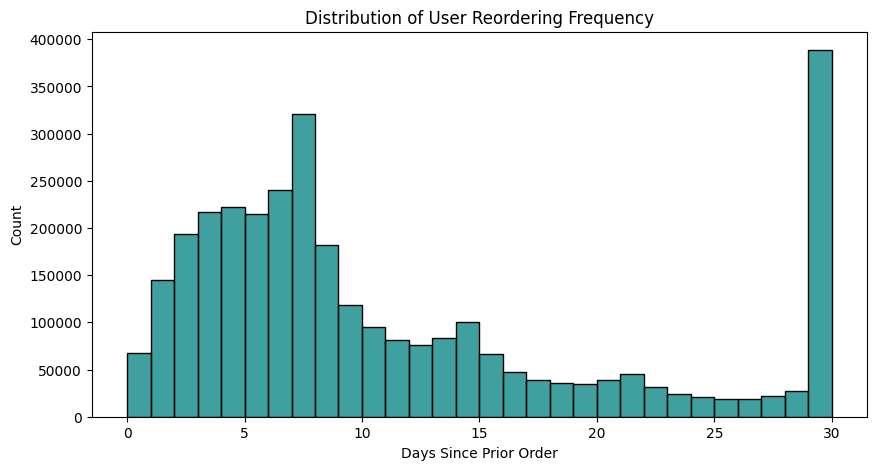

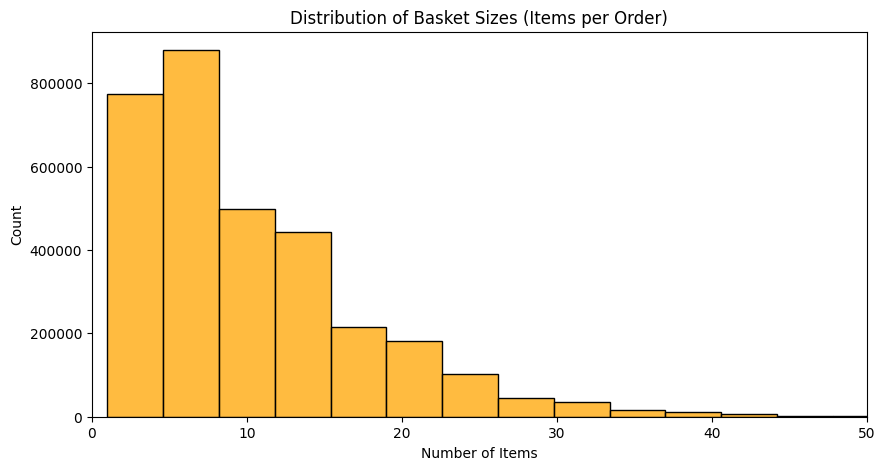

/tmp/ipython-input-4249289850.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_product_names.values, y=order_products_prior['product_id'].value_counts().head(10).values, palette='viridis')


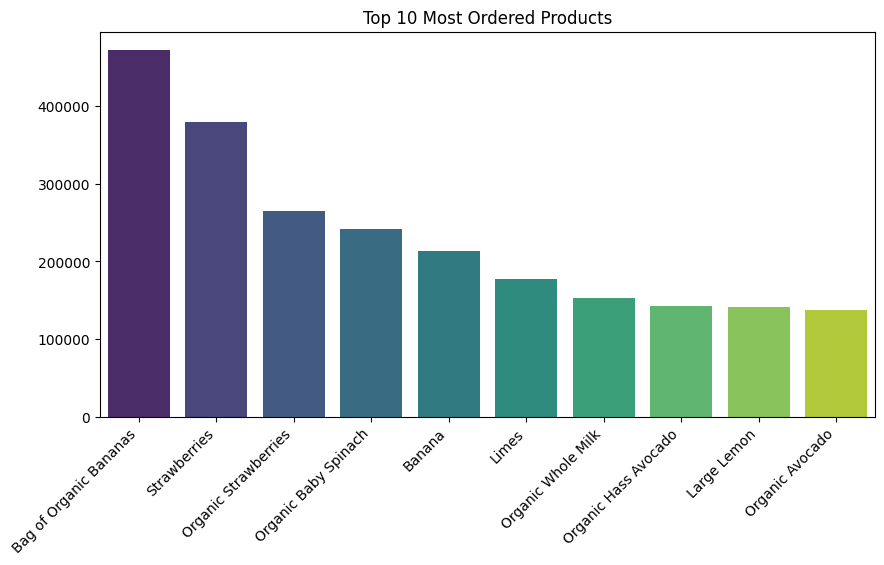

--- Outlier Detection ---
Max items in one order: 145
Max orders by one user: 100

OUTLIER DETECTION & TREATMENT ANALYSIS

Days Since Prior Order:
  Q1: 4.00, Q3: 15.00, IQR: 11.00
  Lower Bound: -12.50, Upper Bound: 31.50
  Outliers: 0 (0.00%)
  Min outlier: nan, Max outlier: nan

Order Number:
  Q1: 5.00, Q3: 23.00, IQR: 18.00
  Lower Bound: -22.00, Upper Bound: 50.00
  Outliers: 216,870 (6.34%)
  Min outlier: 51.00, Max outlier: 100.00

Basket Size:
  Q1: 5.00, Q3: 14.00, IQR: 9.00
  Lower Bound: -8.50, Upper Bound: 27.50
  Outliers: 105,058 (3.27%)
  Min outlier: 28.00, Max outlier: 145.00

Orders per User:
  Q1: 6.00, Q3: 20.00, IQR: 14.00
  Lower Bound: -15.00, Upper Bound: 41.00
  Outliers: 17,017 (8.25%)
  Min outlier: 42.00, Max outlier: 100.00


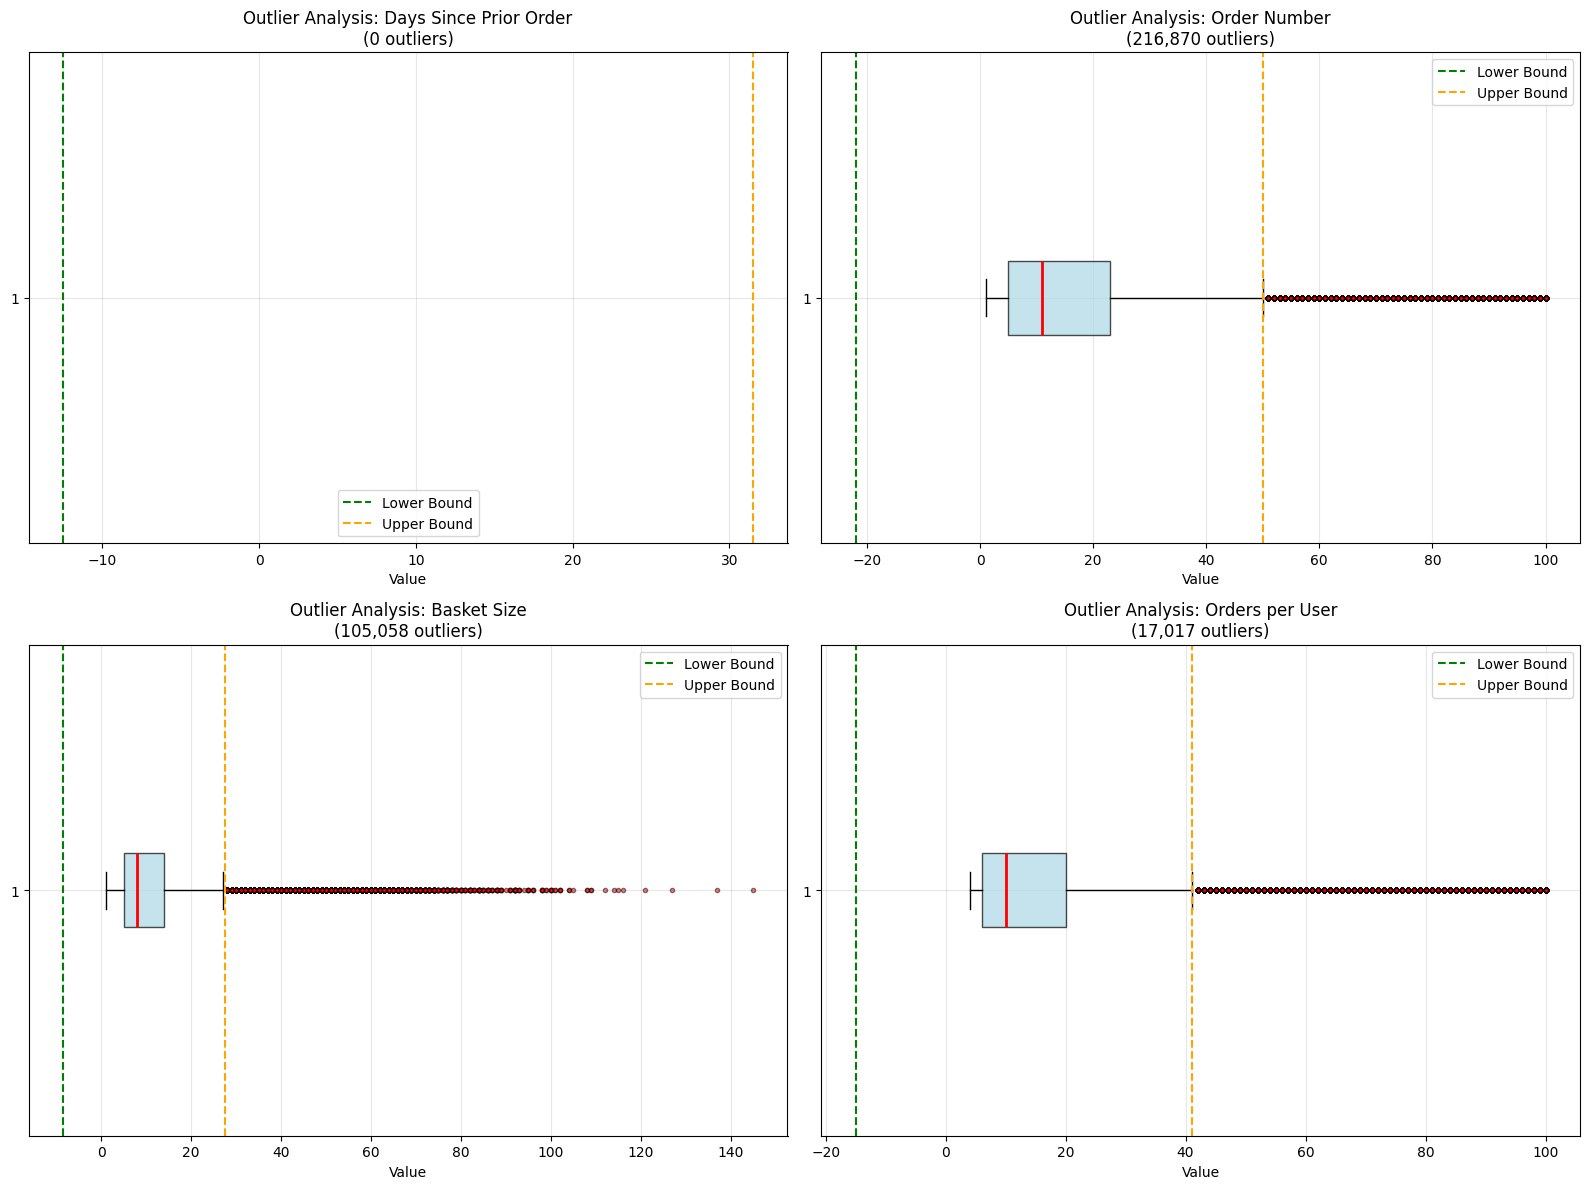

In [53]:

import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Days Since Prior Order
plt.figure(figsize=(10, 5))
sns.histplot(orders['days_since_prior_order'].dropna(), bins=30, kde=False, color='teal')
plt.title('Distribution of User Reordering Frequency')
plt.xlabel('Days Since Prior Order')
plt.ylabel('Count')
plt.show()

# Basket Size Analysis {Items per Order}
basket_sizes = order_products_prior.groupby('order_id')['product_id'].count()

plt.figure(figsize=(10, 5))
sns.histplot(basket_sizes, bins=40, kde=False, color='orange')
plt.title('Distribution of Basket Sizes (Items per Order)')
plt.xlabel('Number of Items')
plt.xlim(0, 50) # Cap at 50 for readability
plt.show()

# Top 10 Popular Products
top_products = order_products_prior['product_id'].value_counts().head(10).index

top_product_names = products[products['product_id'].isin(top_products)]['product_name']

plt.figure(figsize=(10, 5))
sns.barplot(x=top_product_names.values, y=order_products_prior['product_id'].value_counts().head(10).values, palette='viridis')
plt.title('Top 10 Most Ordered Products')
plt.xticks(rotation=45, ha='right')
plt.show()

#  Outlier Detection
# Check for  bots or massive orders
print("--- Outlier Detection ---")
print(f"Max items in one order: {basket_sizes.max()}")
print(f"Max orders by one user: {orders.groupby('user_id').size().max()}")


print("\n" + "="*80)
print("OUTLIER DETECTION & TREATMENT ANALYSIS")
print("="*80)

def detect_outliers_iqr(series, name):
    """Detect outliers using IQR method"""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = series[(series < lower_bound) | (series > upper_bound)]
    outlier_pct = (len(outliers) / len(series)) * 100

    print(f"\n{name}:")
    print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"  Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")
    print(f"  Outliers: {len(outliers):,} ({outlier_pct:.2f}%)")
    print(f"  Min outlier: {outliers.min():.2f}, Max outlier: {outliers.max():.2f}")

    return outliers, lower_bound, upper_bound

# Analyze outliers in key features
basket_sizes = order_products_prior.groupby('order_id')['product_id'].count()
orders_per_user = orders.groupby('user_id')['order_id'].count()

outlier_features = {
    'Days Since Prior Order': orders['days_since_prior_order'],
    'Order Number': orders['order_number'],
    'Basket Size': basket_sizes,
    'Orders per User': orders_per_user
}

outlier_results = {}
for name, series in outlier_features.items():
    outliers, lower, upper = detect_outliers_iqr(series, name)
    outlier_results[name] = (outliers, lower, upper)

# Visualize outliers
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (name, series) in enumerate(outlier_features.items()):
    outliers, lower, upper = outlier_results[name]

    axes[idx].boxplot(series, vert=False, patch_artist=True,
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2),
                     flierprops=dict(marker='o', markerfacecolor='red',
                                   markersize=3, alpha=0.5))
    axes[idx].axvline(lower, color='green', linestyle='--', label='Lower Bound')
    axes[idx].axvline(upper, color='orange', linestyle='--', label='Upper Bound')
    axes[idx].set_title(f'Outlier Analysis: {name}\n({len(outliers):,} outliers)')
    axes[idx].set_xlabel('Value')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()



In [54]:
# reducing the memory
orders = reduce_mem_usage(orders)
products = reduce_mem_usage(products)
departments = reduce_mem_usage(departments)
aisles = reduce_mem_usage(aisles)
order_products_prior = reduce_mem_usage(order_products_prior)
order_products_train = reduce_mem_usage(order_products_train)
print("Memory reduction complete.")

Memory reduction complete.


In [55]:
# merging the tables
# Merge safely to create the full product info
products_full = (
    products
    .merge(aisles, on="aisle_id", how="left")
    .merge(departments, on="department_id", how="left")
)

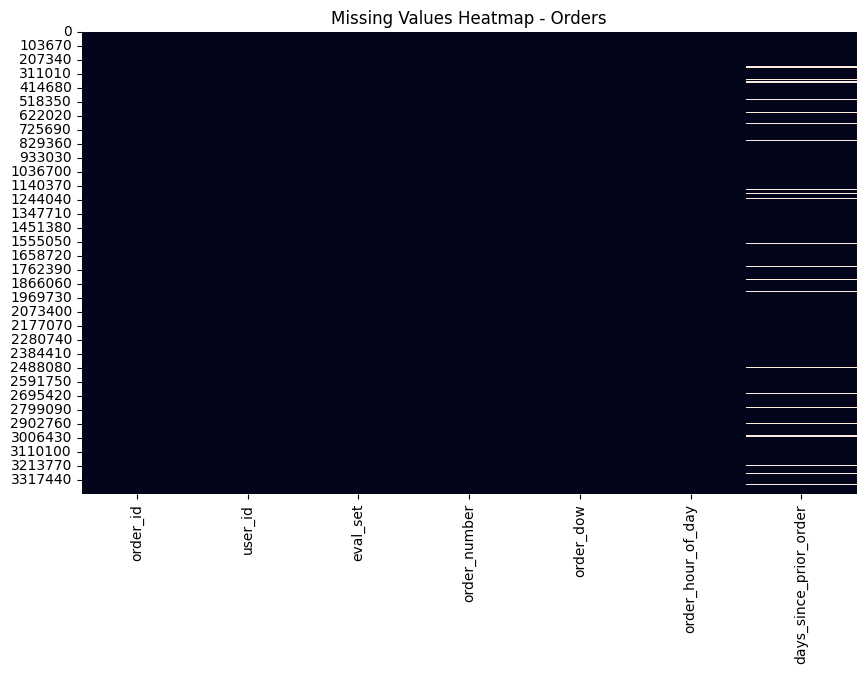

In [56]:
# missing value visulisation
plt.figure(figsize=(10, 6))
sns.heatmap(orders.isnull(), cbar=False)
plt.title("Missing Values Heatmap - Orders")
plt.show()


COMPREHENSIVE MISSING VALUE ANALYSIS - ALL TABLES

Missing Values Summary:
 Table                 Column  Missing_Count  Missing_Percentage Data_Type
orders days_since_prior_order         206209            6.027594   float16


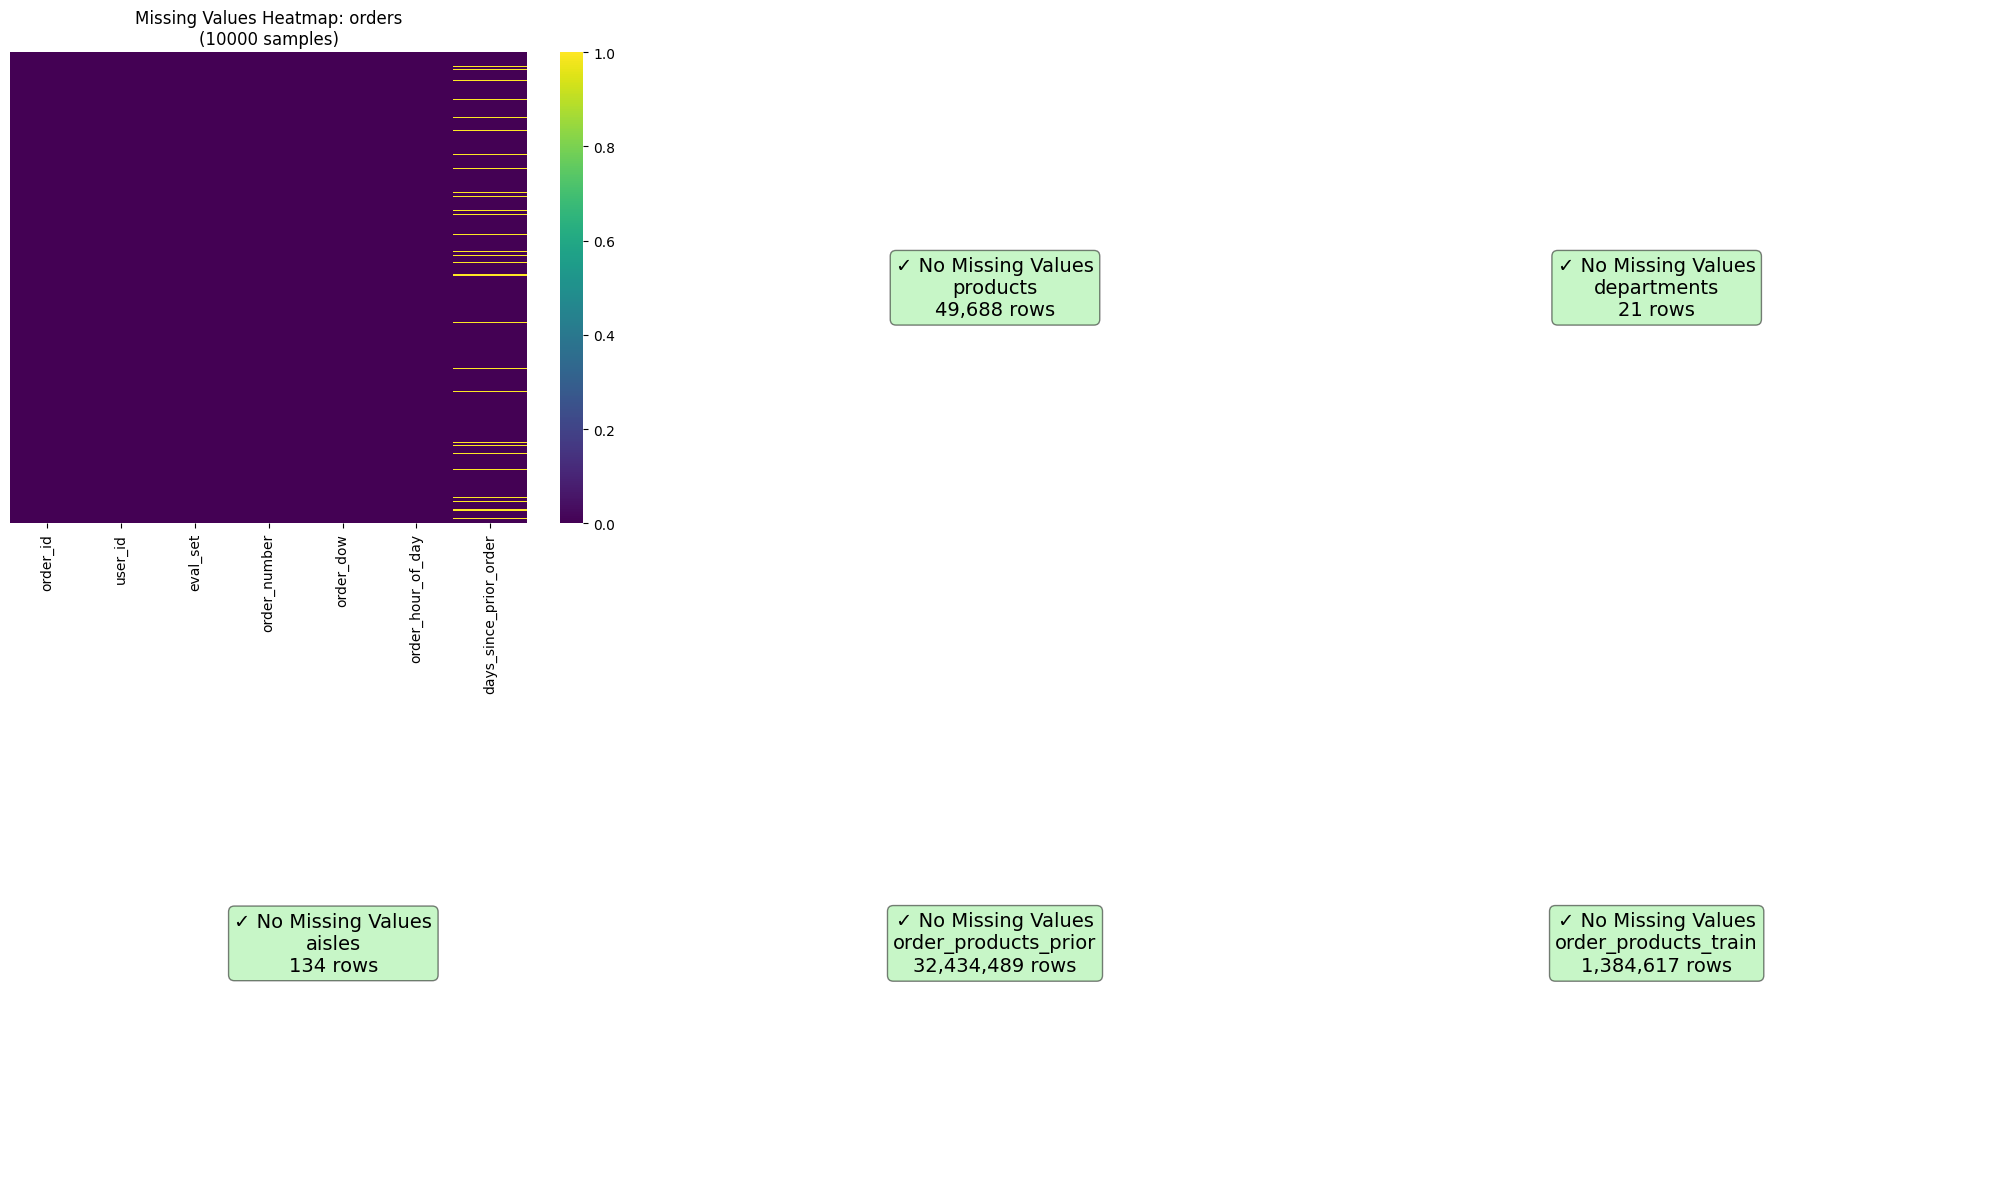

In [57]:
print("\n" + "="*80)
print("COMPREHENSIVE MISSING VALUE ANALYSIS - ALL TABLES")
print("="*80)

tables_dict = {
    'orders': orders,
    'products': products,
    'departments': departments,
    'aisles': aisles,
    'order_products_prior': order_products_prior,
    'order_products_train': order_products_train
}

# Create summary table
missing_summary = []
for name, df in tables_dict.items():
    for col in df.columns:
        missing_count = df[col].isnull().sum()
        missing_pct = (missing_count / len(df)) * 100
        if missing_count > 0:
            missing_summary.append({
                'Table': name,
                'Column': col,
                'Missing_Count': missing_count,
                'Missing_Percentage': missing_pct,
                'Data_Type': df[col].dtype
            })

if missing_summary:
    missing_df = pd.DataFrame(missing_summary)
    print("\nMissing Values Summary:")
    print(missing_df.to_string(index=False))
else:
    print("\n✓ No missing values found in any table after imputation!")

# Visualize missing values for all tables
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, (name, df) in enumerate(tables_dict.items()):
    missing_pct = (df.isnull().sum() / len(df)) * 100
    if missing_pct.sum() > 0:
        # Sample if dataset is too large for visualization
        sample_size = min(10000, len(df))
        df_sample = df.sample(n=sample_size, random_state=42)
        sns.heatmap(df_sample.isnull(), cbar=True, ax=axes[idx],
                   yticklabels=False, cmap='viridis')
        axes[idx].set_title(f'Missing Values Heatmap: {name}\n({sample_size} samples)')
    else:
        axes[idx].text(0.5, 0.5, f'✓ No Missing Values\n{name}\n{len(df):,} rows',
                      ha='center', va='center', fontsize=14,
                      bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
        axes[idx].set_xlim(0, 1)
        axes[idx].set_ylim(0, 1)
        axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [58]:
# Imputation was chosen as NaN indicates the first order for the user (0 days)
orders["days_since_prior_order"] = orders["days_since_prior_order"].fillna(0)

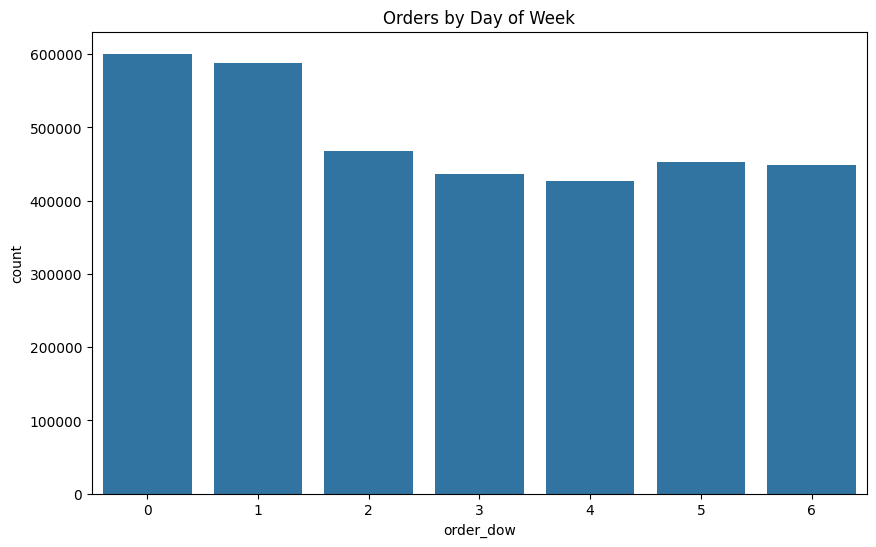

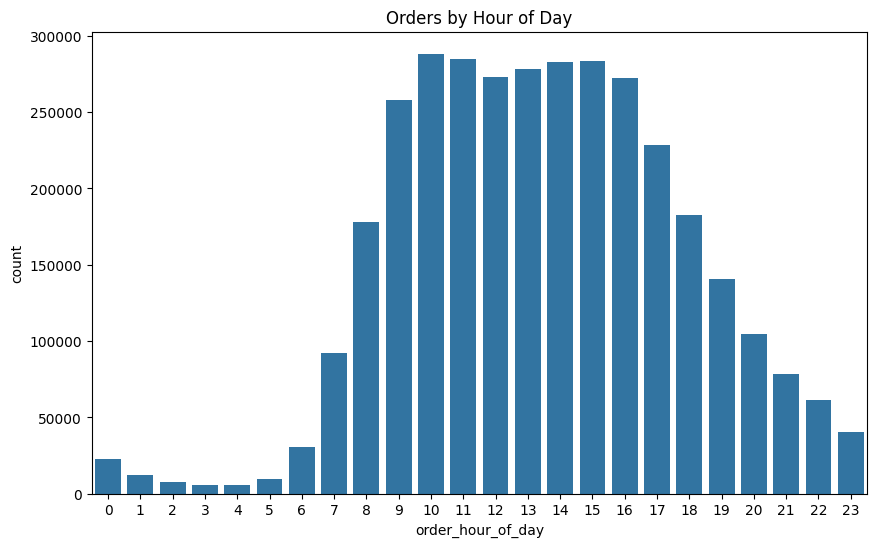

In [59]:
# A Day
plt.figure(figsize=(10, 6))
sns.countplot(x="order_dow", data=orders)
plt.title("Orders by Day of Week")
plt.show()

# hour
plt.figure(figsize=(10, 6))
sns.countplot(x="order_hour_of_day", data=orders)
plt.title("Orders by Hour of Day")
plt.show()


TEMPORAL SEASONALITY ANALYSIS

Hourly Statistics:
                   order_count  avg_basket_size  std_basket_size  \
order_hour_of_day                                                  
0                        21372            10.24             7.80   
1                        11596             9.98             7.83   
2                         7070             9.82             7.79   
3                         5120            10.02             7.83   
4                         5175            10.30             8.28   
5                         8972             9.82             7.70   
6                        28792            10.10             7.78   
7                        86656            10.29             7.68   
8                       168321            10.22             7.73   
9                       243496            10.09             7.74   
10                      271885            10.17             7.77   
11                      268006            10.22             7.73 

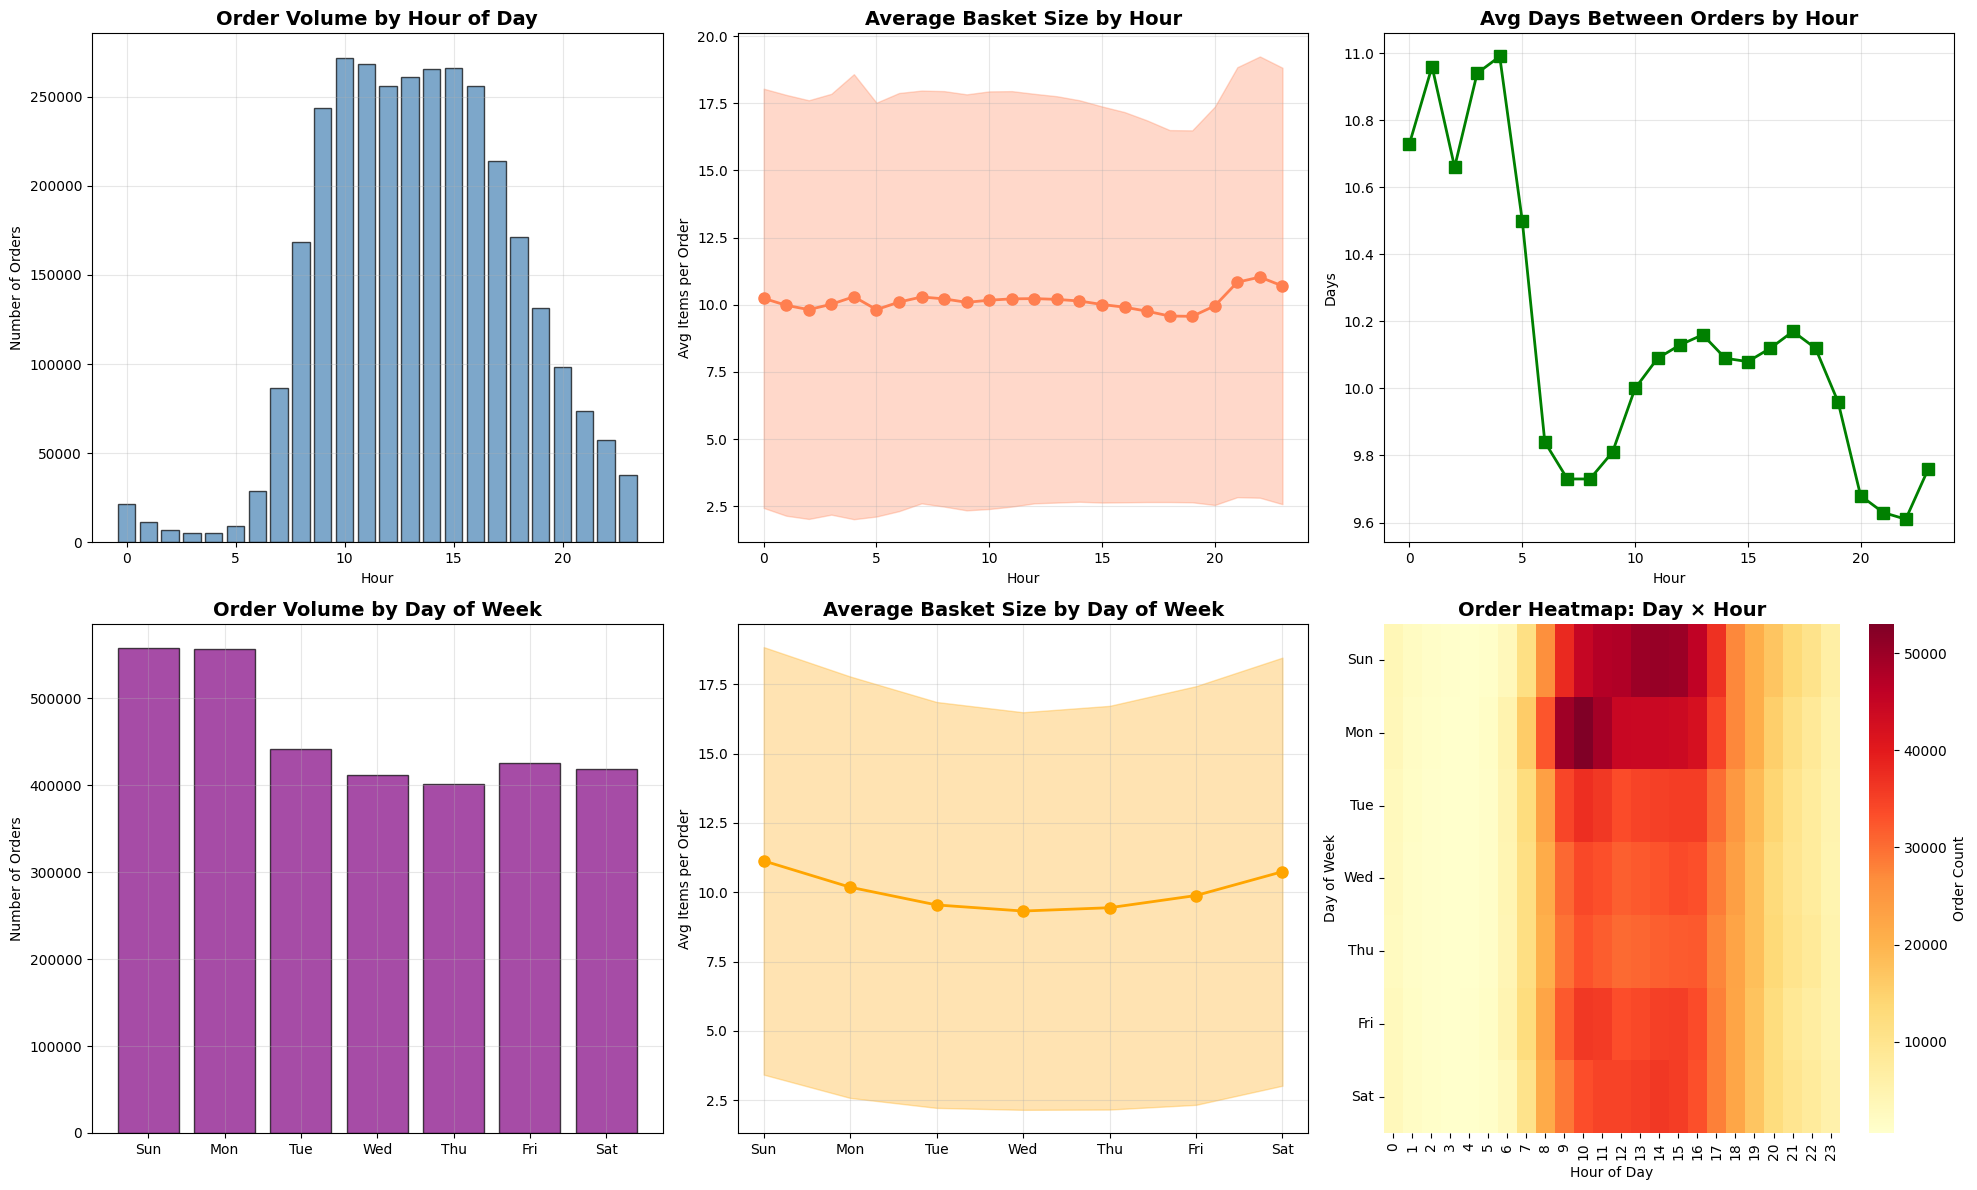


 KEY SEASONALITY INSIGHTS:
  • Peak ordering hour: 10:00
  • Peak ordering day: Sun
  • Largest baskets occur at hour: 22:00


In [60]:
print("\n" + "="*80)
print("TEMPORAL SEASONALITY ANALYSIS")
print("="*80)

# Merge orders with basket sizes for richer analysis
orders_with_basket = orders[orders.eval_set == 'prior'].merge(
    order_products_prior.groupby('order_id').size().rename('basket_size'),
    left_on='order_id', right_index=True, how='left'
)

# Hourly patterns
hourly_stats = orders_with_basket.groupby('order_hour_of_day').agg({
    'order_id': 'count',
    'basket_size': ['mean', 'std'],
    'days_since_prior_order': 'mean'
}).round(2)
hourly_stats.columns = ['order_count', 'avg_basket_size', 'std_basket_size', 'avg_days_between']

print("\nHourly Statistics:")
print(hourly_stats)

#  Day of week patterns
daily_stats = orders_with_basket.groupby('order_dow').agg({
    'order_id': 'count',
    'basket_size': ['mean', 'std'],
    'days_since_prior_order': 'mean'
}).round(2)
daily_stats.columns = ['order_count', 'avg_basket_size', 'std_basket_size', 'avg_days_between']

print("\nDaily Statistics:")
print(daily_stats)

# Visualize seasonality
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Hour of day ------ order volume
axes[0, 0].bar(hourly_stats.index, hourly_stats['order_count'],
              color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Order Volume by Hour of Day', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Number of Orders')
axes[0, 0].grid(alpha=0.3)

# Hour of day ------ average basket size
axes[0, 1].plot(hourly_stats.index, hourly_stats['avg_basket_size'],
               marker='o', color='coral', linewidth=2, markersize=8)
axes[0, 1].fill_between(hourly_stats.index,
                        hourly_stats['avg_basket_size'] - hourly_stats['std_basket_size'],
                        hourly_stats['avg_basket_size'] + hourly_stats['std_basket_size'],
                        alpha=0.3, color='coral')
axes[0, 1].set_title('Average Basket Size by Hour', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Avg Items per Order')
axes[0, 1].grid(alpha=0.3)

# Hour of day ------- reorder frequency
axes[0, 2].plot(hourly_stats.index, hourly_stats['avg_days_between'],
               marker='s', color='green', linewidth=2, markersize=8)
axes[0, 2].set_title('Avg Days Between Orders by Hour', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Hour')
axes[0, 2].set_ylabel('Days')
axes[0, 2].grid(alpha=0.3)

# Day of week --------- order volume
day_labels = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
axes[1, 0].bar(range(7), daily_stats['order_count'],
              color='purple', edgecolor='black', alpha=0.7)
axes[1, 0].set_xticks(range(7))
axes[1, 0].set_xticklabels(day_labels)
axes[1, 0].set_title('Order Volume by Day of Week', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Number of Orders')
axes[1, 0].grid(alpha=0.3)

# Day of week --------- average basket size
axes[1, 1].plot(range(7), daily_stats['avg_basket_size'],
               marker='o', color='orange', linewidth=2, markersize=8)
axes[1, 1].fill_between(range(7),
                        daily_stats['avg_basket_size'] - daily_stats['std_basket_size'],
                        daily_stats['avg_basket_size'] + daily_stats['std_basket_size'],
                        alpha=0.3, color='orange')
axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels(day_labels)
axes[1, 1].set_title('Average Basket Size by Day of Week', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Avg Items per Order')
axes[1, 1].grid(alpha=0.3)

# Combined heatmap: Hour x Day
heatmap_data = orders_with_basket.groupby(['order_dow', 'order_hour_of_day']).size().unstack(fill_value=0)
sns.heatmap(heatmap_data, cmap='YlOrRd', ax=axes[1, 2], cbar_kws={'label': 'Order Count'})
axes[1, 2].set_title('Order Heatmap: Day × Hour', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Hour of Day')
axes[1, 2].set_ylabel('Day of Week')
axes[1, 2].set_yticklabels(day_labels, rotation=0)

plt.tight_layout()
plt.show()

print("\n KEY SEASONALITY INSIGHTS:")
peak_hour = hourly_stats['order_count'].idxmax()
peak_day = daily_stats['order_count'].idxmax()
print(f"  • Peak ordering hour: {peak_hour}:00")
print(f"  • Peak ordering day: {day_labels[peak_day]}")
print(f"  • Largest baskets occur at hour: {hourly_stats['avg_basket_size'].idxmax()}:00")



Rows to plot: 10


/tmp/ipython-input-1779202202.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="product_name", x="count", data=top_products, palette='viridis')


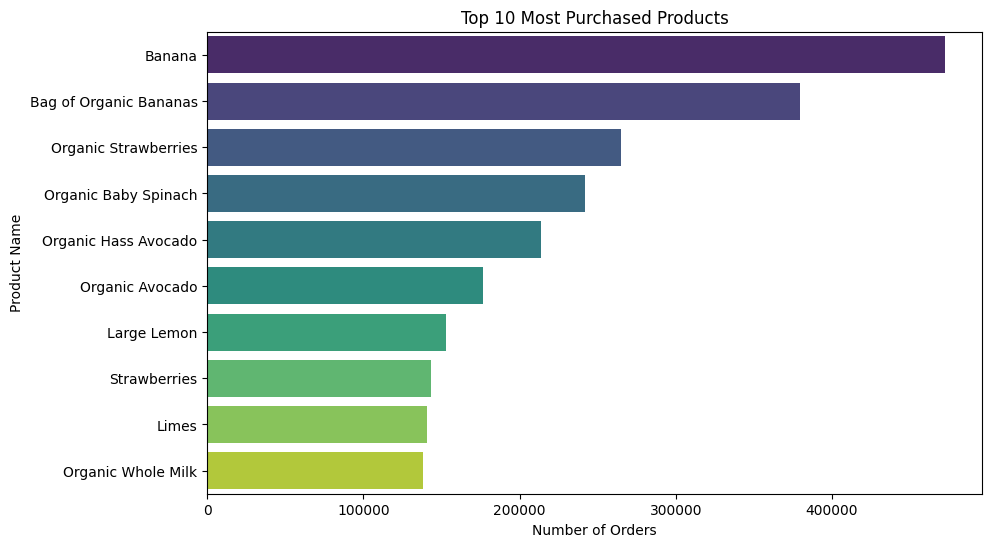

In [61]:
# Calculate the top 10
top_products_counts = order_products_prior["product_id"].value_counts().head(10).reset_index()
top_products_counts.columns = ['product_id', 'count']

# Merge with product names
top_products = top_products_counts.merge(products, on="product_id")

#  Convert 'product_name' from Category to String
# This stops the plot from trying to show hidden categories
top_products['product_name'] = top_products['product_name'].astype(str)

#Sanity Check: Ensure we only have 10 rows
print(f"Rows to plot: {top_products.shape[0]}") # Should say 10
if top_products.shape[0] > 10:
    top_products = top_products.head(10) # Force limit if merge expanded it

#  Plot Cleanly
plt.figure(figsize=(10, 6))
sns.barplot(y="product_name", x="count", data=top_products, palette='viridis')
plt.title("Top 10 Most Purchased Products")
plt.xlabel("Number of Orders")
plt.ylabel("Product Name")
plt.show()

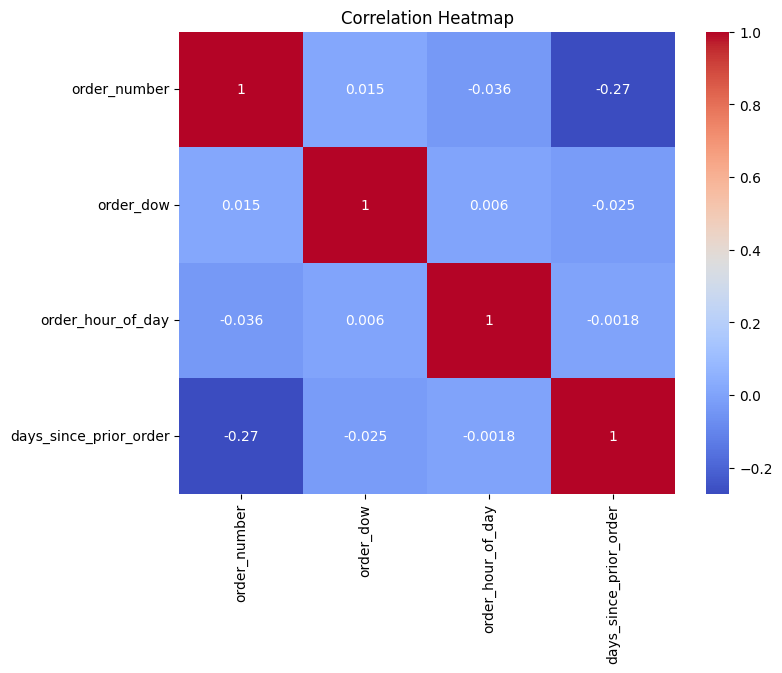

In [62]:
# correlation heatmap
corr_df = orders[["order_number", "order_dow", "order_hour_of_day", "days_since_prior_order"]]
plt.figure(figsize=(8,6))
sns.heatmap(corr_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


ENHANCED CORRELATION ANALYSIS

Correlation Matrix:
                        order_number  order_dow  order_hour_of_day  \
order_number                   1.000      0.015             -0.036   
order_dow                      0.015      1.000              0.006   
order_hour_of_day             -0.036      0.006              1.000   
days_since_prior_order        -0.266     -0.026             -0.003   
basket_size                   -0.004     -0.025             -0.006   

                        days_since_prior_order  basket_size  
order_number                            -0.266       -0.004  
order_dow                               -0.026       -0.025  
order_hour_of_day                       -0.003       -0.006  
days_since_prior_order                   1.000        0.055  
basket_size                              0.055        1.000  


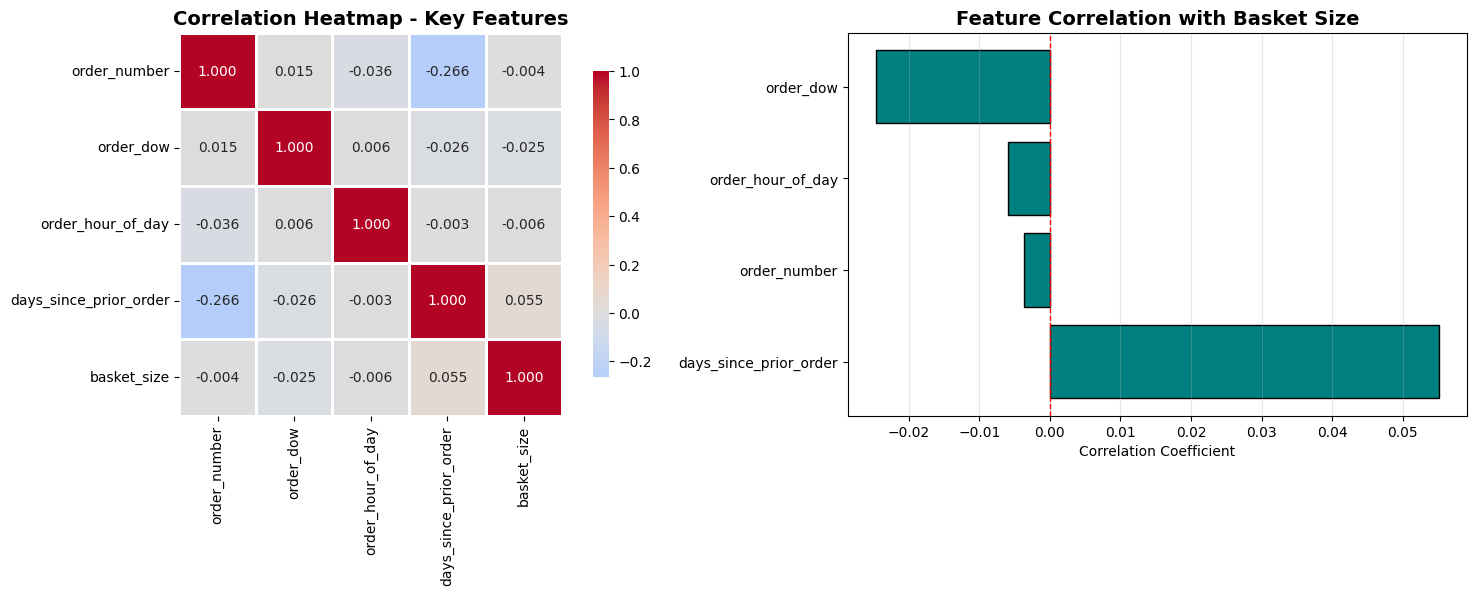


Generating pairwise scatter plots...


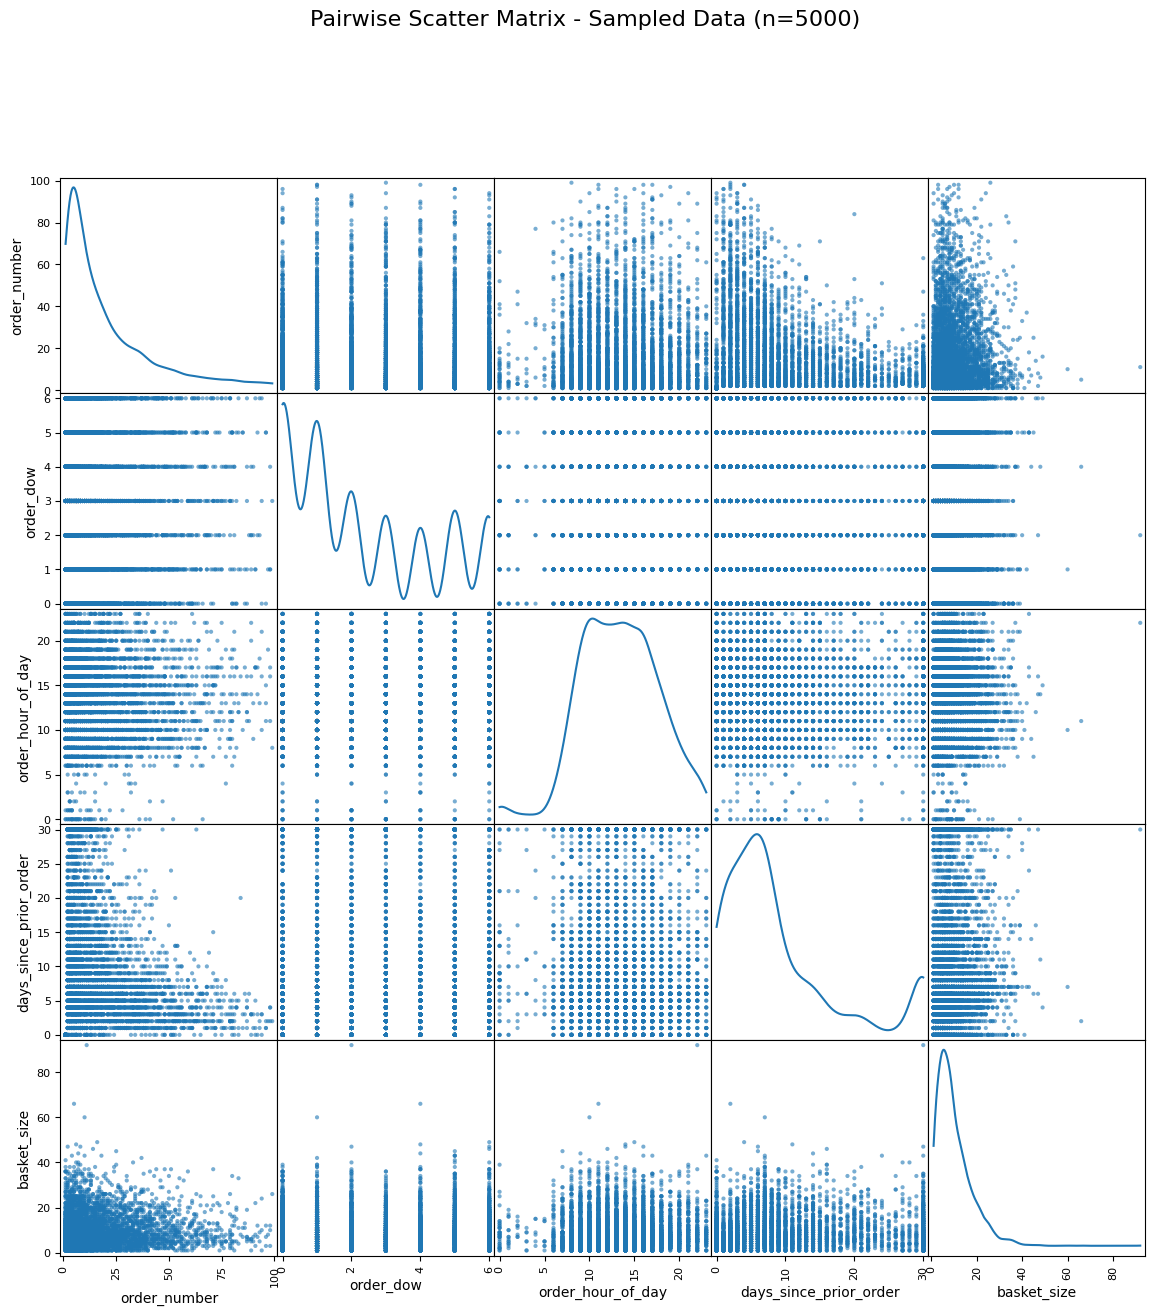

In [63]:
print("\n" + "="*80)
print("ENHANCED CORRELATION ANALYSIS")
print("="*80)

# Create a richer feature set for correlation
correlation_features = orders_with_basket[['order_number', 'order_dow', 'order_hour_of_day',
                                            'days_since_prior_order', 'basket_size']].copy()

# Calculate correlation matrix
corr_matrix = correlation_features.corr()

print("\nCorrelation Matrix:")
print(corr_matrix.round(3))

# Visualize correlations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap with annotations
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
           square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[0])
axes[0].set_title('Correlation Heatmap - Key Features', fontsize=14, fontweight='bold')

# Correlation with basket_size (target proxy)
basket_corr = corr_matrix['basket_size'].sort_values(ascending=False)
basket_corr = basket_corr[basket_corr.index != 'basket_size']
axes[1].barh(range(len(basket_corr)), basket_corr.values, color='teal', edgecolor='black')
axes[1].set_yticks(range(len(basket_corr)))
axes[1].set_yticklabels(basket_corr.index)
axes[1].set_xlabel('Correlation Coefficient')
axes[1].set_title('Feature Correlation with Basket Size', fontsize=14, fontweight='bold')
axes[1].axvline(0, color='red', linestyle='--', linewidth=1)
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Pairwise scatter plots for top correlated features
print("\nGenerating pairwise scatter plots...")
from pandas.plotting import scatter_matrix

sample_for_scatter = correlation_features.sample(n=5000, random_state=42)
scatter_matrix(sample_for_scatter, figsize=(14, 14), diagonal='kde',
              alpha=0.6, marker='.', hist_kwds={'bins': 30})
plt.suptitle('Pairwise Scatter Matrix - Sampled Data (n=5000)', y=1.0, fontsize=16)
plt.show()


Reloading CSVs for EDA...
Data reloaded.
Applying memory reduction...
Memory reduction complete.
COMPREHENSIVE EDA ----- DISTRIBUTION ANALYSIS


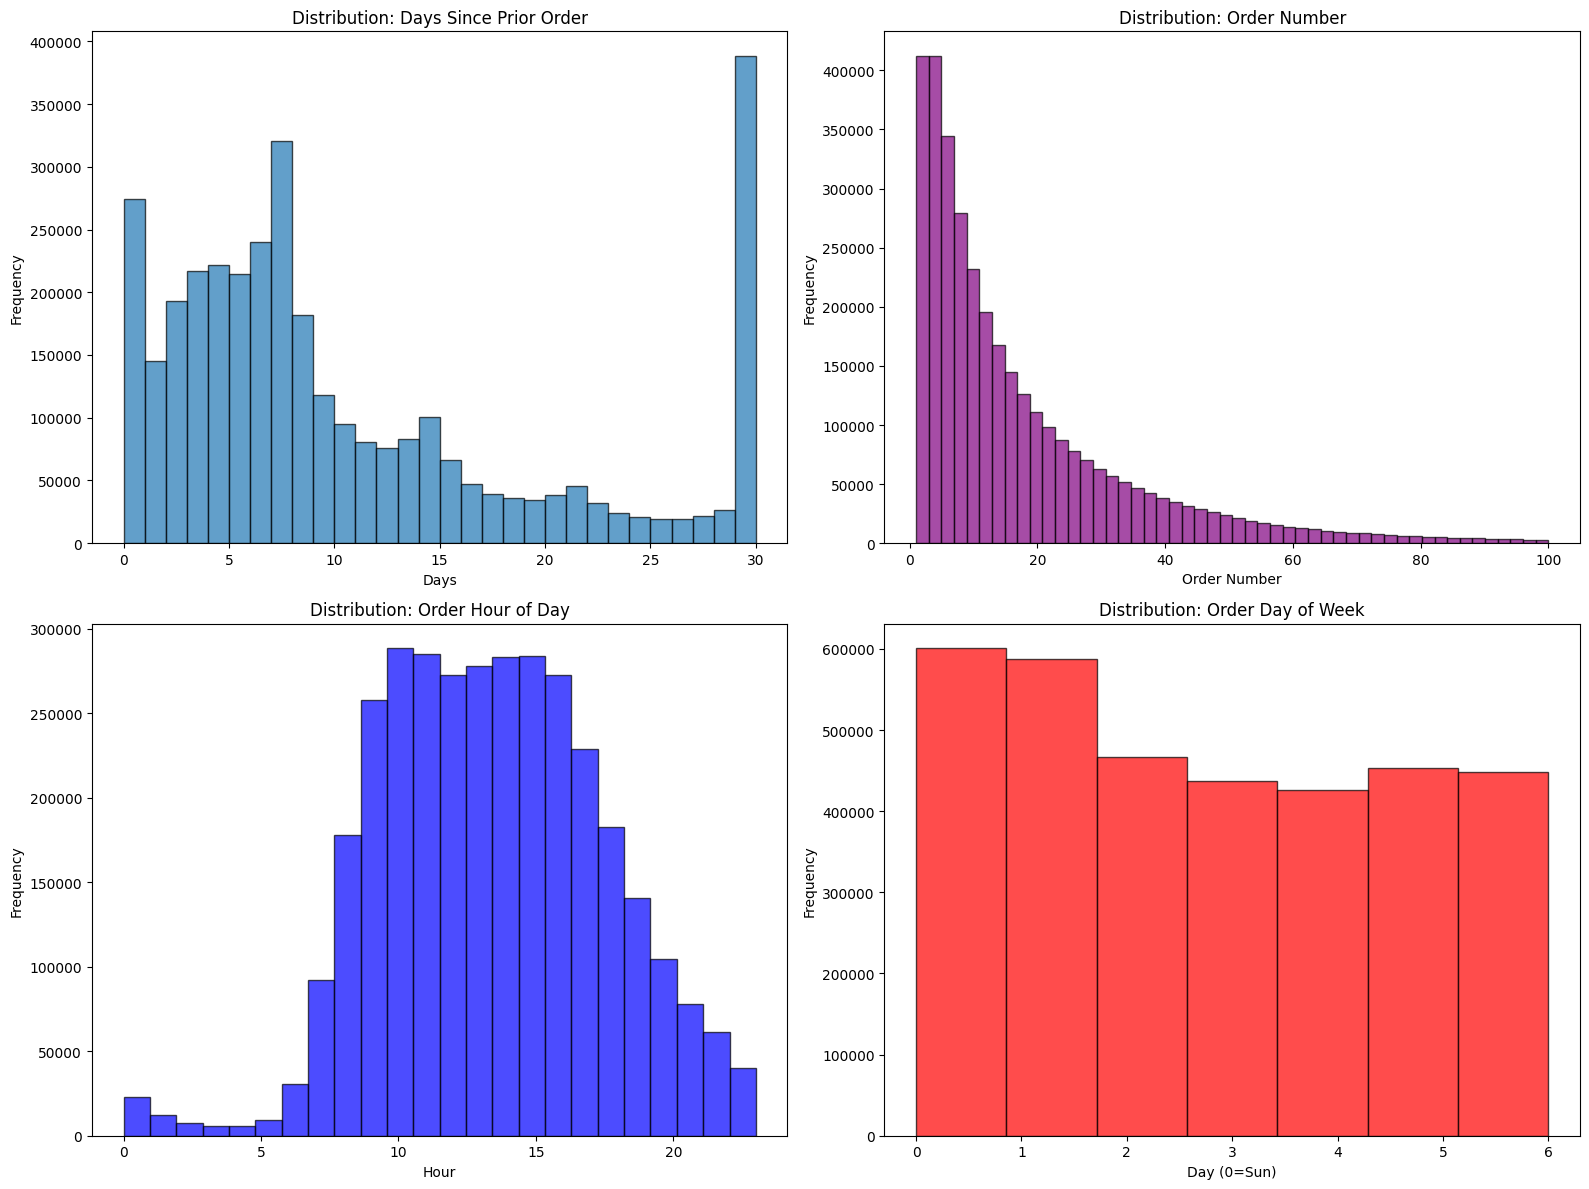

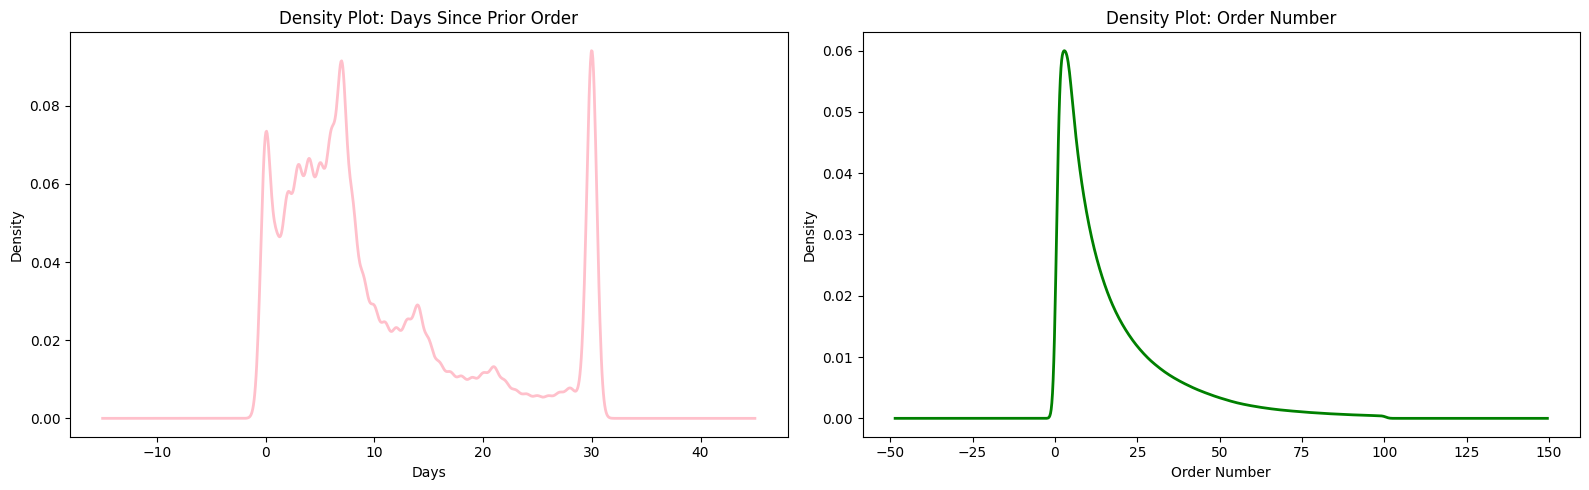


CATEGORICAL CARDINALITY ANALYSIS
Number of unique products: 49688
Number of unique aisles: 134
Number of unique departments: 21
Number of unique users: 206209


/tmp/ipython-input-300153281.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dept_counts.values, y=dept_counts.index, palette='viridis')


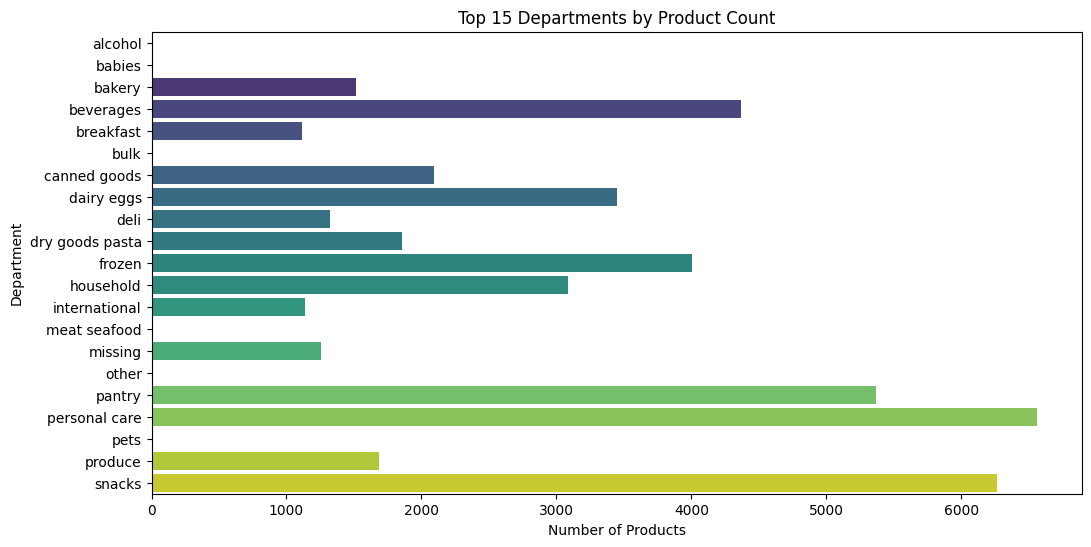

/tmp/ipython-input-300153281.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=aisle_counts.values, y=aisle_counts.index, palette='plasma')


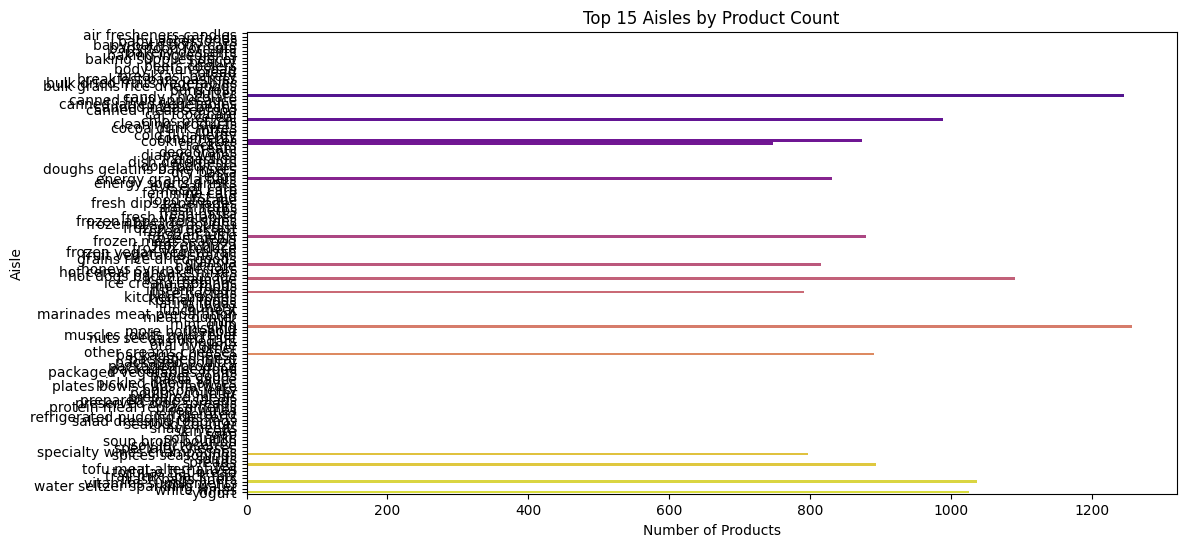


PAIRWISE SCATTER PLOTS


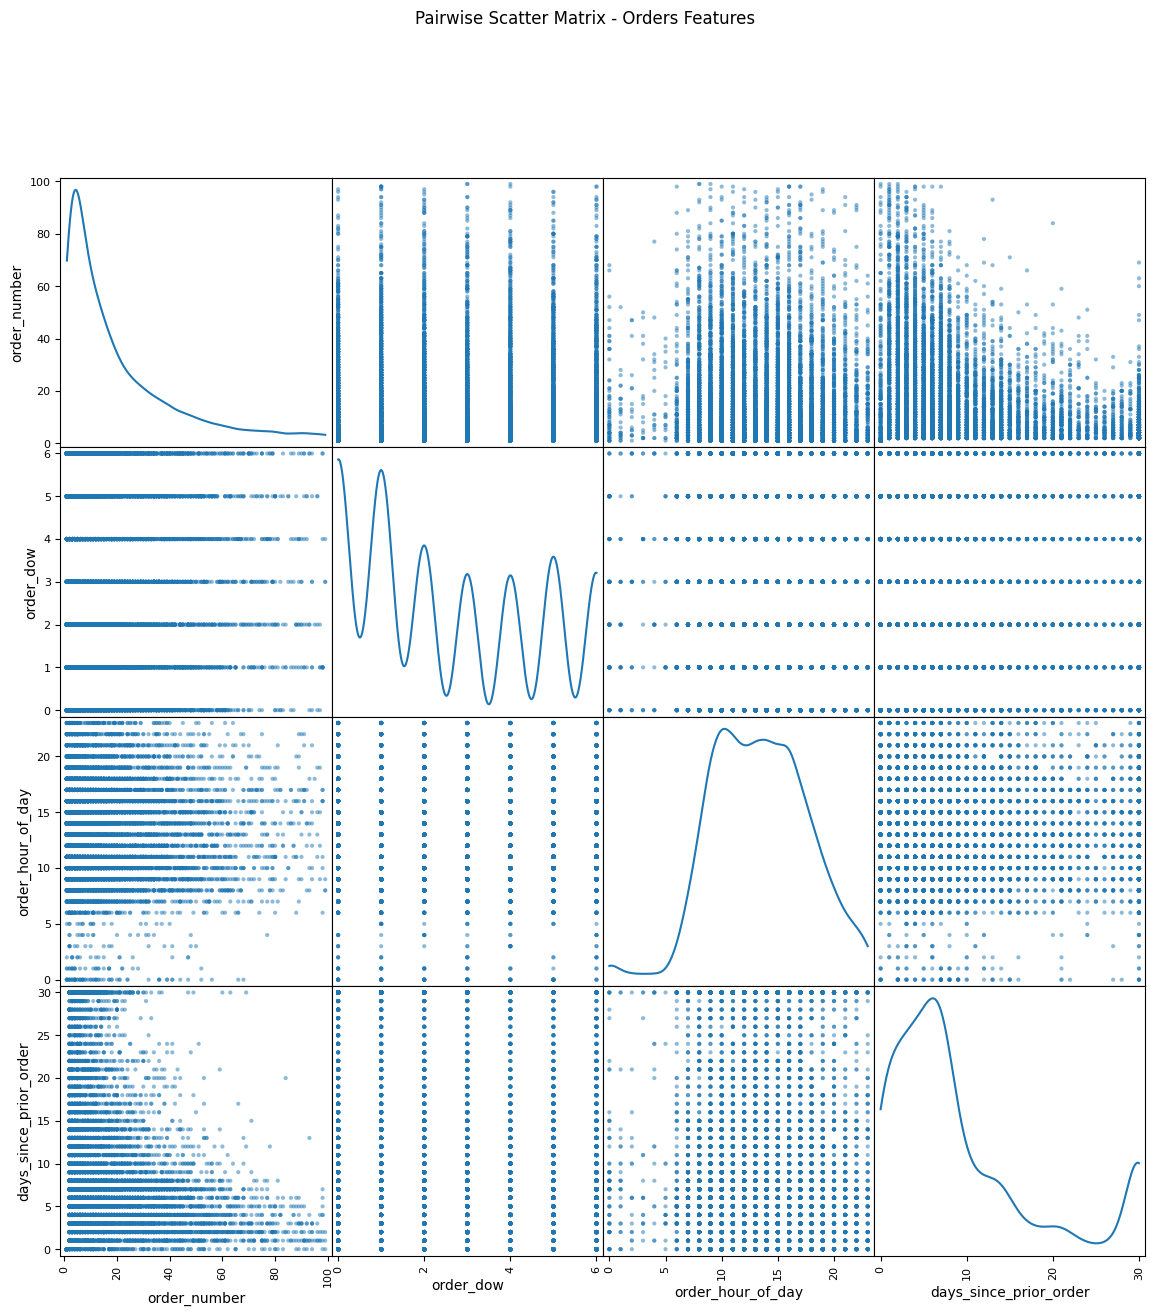


MISSING VALUES ANALYSIS ------ ALL TABLES


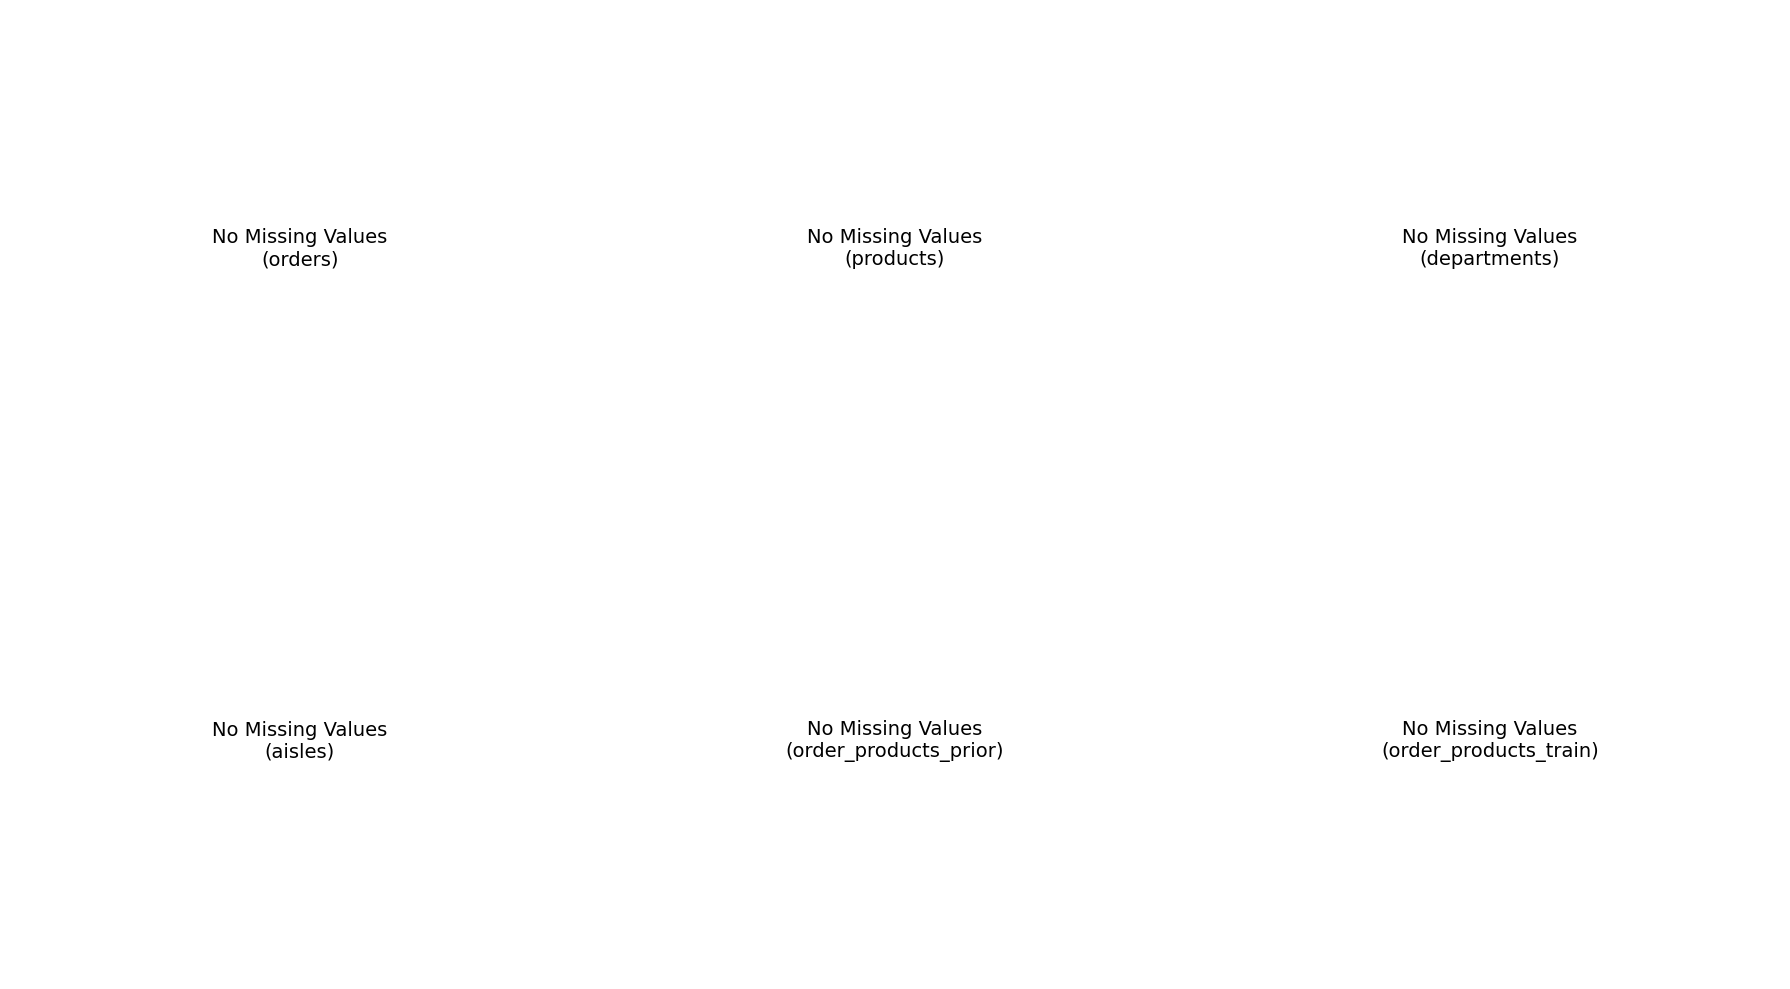

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# reducing the memory to allow scalable joins and faster experimentation
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
        else:
            df[col] = df[col].astype('category')
    return df

# Reloading dataframes needed for this EDA cell, as they were deleted previously
print("Reloading CSVs for EDA...")
orders = pd.read_csv('/content/dataset/orders.csv')
products = pd.read_csv('/content/dataset/products.csv')
departments = pd.read_csv('/content/dataset/departments.csv')
aisles = pd.read_csv('/content/dataset/aisles.csv')
order_products_prior = pd.read_csv('/content/dataset/order_products__prior.csv')
order_products_train = pd.read_csv('/content/dataset/order_products__train.csv')
print("Data reloaded.")

print("Applying memory reduction...")
orders = reduce_mem_usage(orders)
products = reduce_mem_usage(products)
departments = reduce_mem_usage(departments)
aisles = reduce_mem_usage(aisles)
order_products_prior = reduce_mem_usage(order_products_prior)
order_products_train = reduce_mem_usage(order_products_train)
print("Memory reduction complete.")

# Imputation for days_since_prior_order, as done previously
orders["days_since_prior_order"] = orders["days_since_prior_order"].fillna(0)

# Re-create products_full
products_full = (
    products
    .merge(aisles, on="aisle_id", how="left")
    .merge(departments, on="department_id", how="left")
)

print("="*80)
print("COMPREHENSIVE EDA ----- DISTRIBUTION ANALYSIS")
print("="*80)

# Distribution plots for ALL numeric features in orders
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Days since prior order
axes[0, 0].hist(orders['days_since_prior_order'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution: Days Since Prior Order')
axes[0, 0].set_xlabel('Days')
axes[0, 0].set_ylabel('Frequency')

# Order number
axes[0, 1].hist(orders['order_number'], bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[0, 1].set_title('Distribution: Order Number')
axes[0, 1].set_xlabel('Order Number')
axes[0, 1].set_ylabel('Frequency')

# Hour of day
axes[1, 0].hist(orders['order_hour_of_day'], bins=24, edgecolor='black', alpha=0.7, color='blue')
axes[1, 0].set_title('Distribution: Order Hour of Day')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Frequency')

# Day of week
axes[1, 1].hist(orders['order_dow'], bins=7, edgecolor='black', alpha=0.7, color='red')
axes[1, 1].set_title('Distribution: Order Day of Week')
axes[1, 1].set_xlabel('Day (0=Sun)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Density plots with KDE
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

orders['days_since_prior_order'].plot(kind='density', ax=axes[0], color='pink', linewidth=2)
axes[0].set_title('Density Plot: Days Since Prior Order')
axes[0].set_xlabel('Days')

orders['order_number'].plot(kind='density', ax=axes[1], color='green', linewidth=2)
axes[1].set_title('Density Plot: Order Number')
axes[1].set_xlabel('Order Number')

plt.tight_layout()
plt.show()

# Categorical Cardinality Analysis
print("\n" + "="*80)
print("CATEGORICAL CARDINALITY ANALYSIS")
print("="*80)

# Products cardinality
print(f"Number of unique products: {products['product_id'].nunique()}")
print(f"Number of unique aisles: {aisles['aisle_id'].nunique()}")
print(f"Number of unique departments: {departments['department_id'].nunique()}")
print(f"Number of unique users: {orders['user_id'].nunique()}")

# Top 15 departments
dept_counts = products_full['department'].value_counts().head(15)
plt.figure(figsize=(12, 6))
sns.barplot(x=dept_counts.values, y=dept_counts.index, palette='viridis')
plt.title('Top 15 Departments by Product Count')
plt.xlabel('Number of Products')
plt.ylabel('Department')
plt.show()

# Top 15 aisles
aisle_counts = products_full['aisle'].value_counts().head(15)
plt.figure(figsize=(12, 6))
sns.barplot(x=aisle_counts.values, y=aisle_counts.index, palette='plasma')
plt.title('Top 15 Aisles by Product Count')
plt.xlabel('Number of Products')
plt.ylabel('Aisle')
plt.show()

# Pairwise Scatter Plots
print("\n" + "="*80)
print("PAIRWISE SCATTER PLOTS")
print("="*80)

from pandas.plotting import scatter_matrix

# visualization
sample_orders = orders[orders.eval_set == 'prior'].sample(n=10000, random_state=42)
scatter_cols = ['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']

fig = scatter_matrix(sample_orders[scatter_cols], figsize=(14, 14),
                     diagonal='kde', alpha=0.5, marker='.')
plt.suptitle('Pairwise Scatter Matrix - Orders Features', y=1.0)
plt.show()

#  Missing Values Analysis
print("\n" + "="*80)
print("MISSING VALUES ANALYSIS ------ ALL TABLES")
print("="*80)

tables = {
    'orders': orders,
    'products': products,
    'departments': departments,
    'aisles': aisles,
    'order_products_prior': order_products_prior,
    'order_products_train': order_products_train
}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, df) in enumerate(tables.items()):
    missing_pct = (df.isnull().sum() / len(df)) * 100
    if missing_pct.sum() > 0:
        sns.heatmap(df.isnull(), cbar=False, ax=axes[idx], yticklabels=False)
        axes[idx].set_title(f'Missing Values: {name}')
    else:
        axes[idx].text(0.5, 0.5, f'No Missing Values\n({name})',
                      ha='center', va='center', fontsize=14)
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Print summary
for name, df in tables.items():
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\n{name}:")
        print(missing[missing > 0])


COMPREHENSIVE NUMERIC DISTRIBUTION ANALYSIS

Summary Statistics - Orders Table:


/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


       order_number     order_dow  order_hour_of_day  days_since_prior_order
count  3.421083e+06  3.421083e+06       3.421083e+06               3421083.0
mean   1.715486e+01  2.776219e+00       1.345202e+01                     NaN
std    1.773316e+01  2.046829e+00       4.226088e+00                     0.0
min    1.000000e+00  0.000000e+00       0.000000e+00                     0.0
25%    5.000000e+00  1.000000e+00       1.000000e+01                     4.0
50%    1.100000e+01  3.000000e+00       1.300000e+01                     7.0
75%    2.300000e+01  5.000000e+00       1.600000e+01                    15.0
max    1.000000e+02  6.000000e+00       2.300000e+01                    30.0


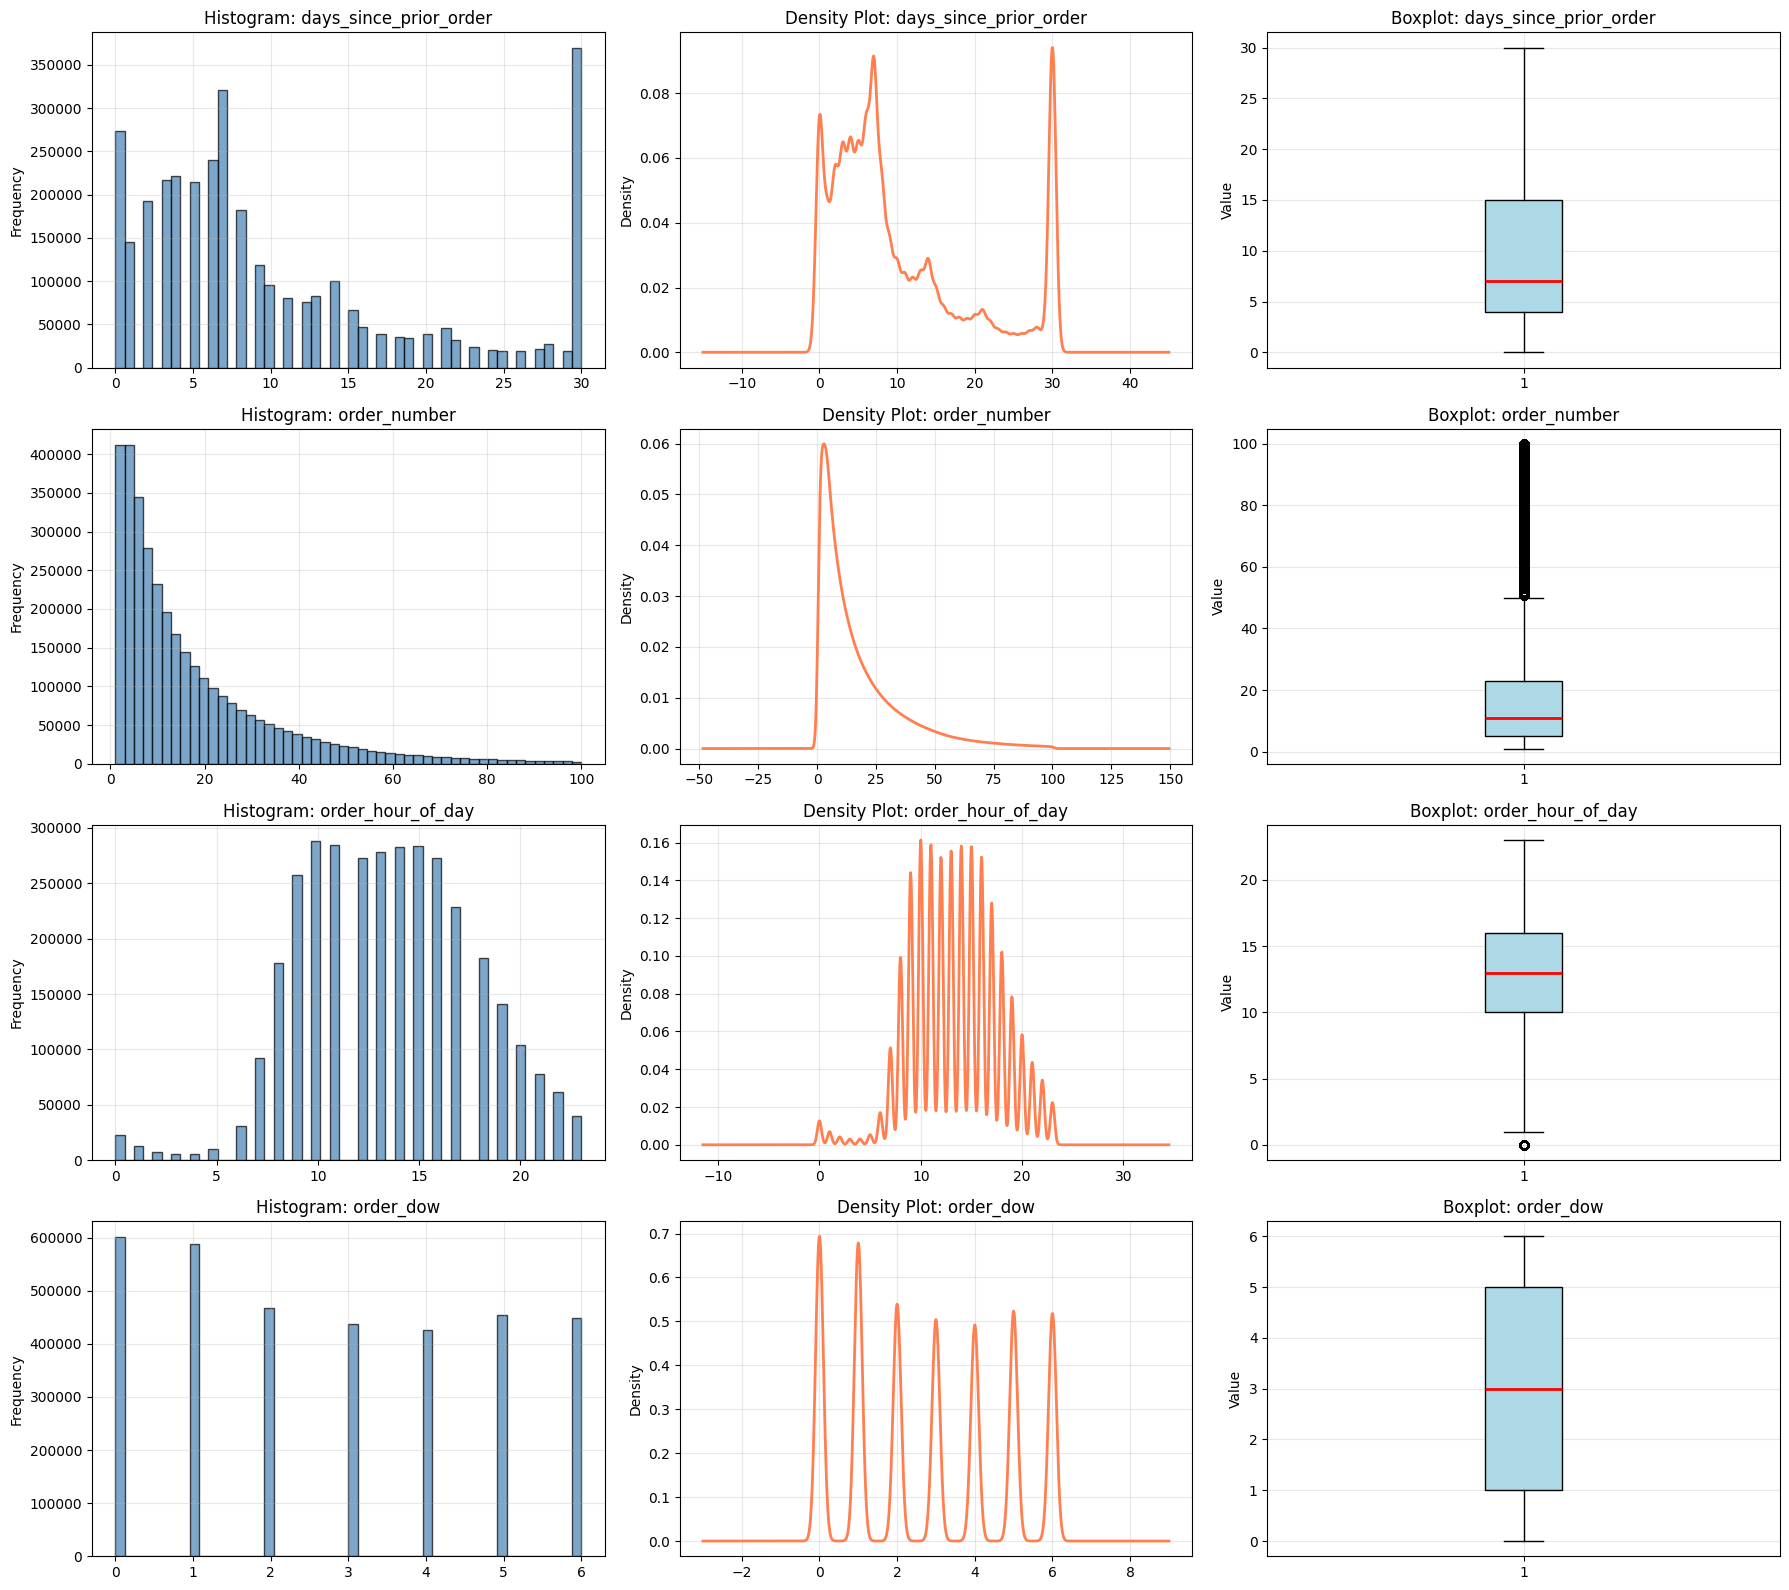

In [65]:
print("\n" + "="*80)
print("COMPREHENSIVE NUMERIC DISTRIBUTION ANALYSIS")
print("="*80)

# Summary statistics
print("\nSummary Statistics - Orders Table:")
print(orders[['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']].describe())

# Combined histogram + density + boxplot for key features
numeric_features = ['days_since_prior_order', 'order_number', 'order_hour_of_day', 'order_dow']

fig, axes = plt.subplots(len(numeric_features), 3, figsize=(18, 16))

for idx, feature in enumerate(numeric_features):
    data = orders[feature].dropna()

    # Histogram
    axes[idx, 0].hist(data, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx, 0].set_title(f'Histogram: {feature}')
    axes[idx, 0].set_ylabel('Frequency')
    axes[idx, 0].grid(alpha=0.3)

    # Density (KDE)
    data.plot(kind='density', ax=axes[idx, 1], color='coral', linewidth=2)
    axes[idx, 1].set_title(f'Density Plot: {feature}')
    axes[idx, 1].set_ylabel('Density')
    axes[idx, 1].grid(alpha=0.3)

    # Boxplot
    axes[idx, 2].boxplot(data, vert=True, patch_artist=True,
                         boxprops=dict(facecolor='lightblue'),
                         medianprops=dict(color='red', linewidth=2))
    axes[idx, 2].set_title(f'Boxplot: {feature}')
    axes[idx, 2].set_ylabel('Value')
    axes[idx, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()



In [66]:
def check_data_integrity():
    print("--- Starting Sanity Checks ---\n")

    # CHECK IMPUTATION
    # We expect 0 missing values in days_since_prior_order now
    missing_days = orders['days_since_prior_order'].isnull().sum()
    assert missing_days == 0, f"FAILED: Found {missing_days} nulls in days_since_prior_order!"
    print(f" Imputation Check: PASSED (0 missing values)")

    # CHECK RANGES (Logical Consistency)
    # Days of week must be 0-6
    assert orders['order_dow'].min() >= 0 and orders['order_dow'].max() <= 6, "FAILED: order_dow out of range (0-6)"
    # Hours must be 0-23
    assert orders['order_hour_of_day'].min() >= 0 and orders['order_hour_of_day'].max() <= 23, "FAILED: Hour out of range (0-23)"
    # Days since prior order (max is usually 30 in this dataset)
    assert orders['days_since_prior_order'].max() <= 30, "FAILED: days_since_prior_order > 30 found"
    print(f" Logical Range Check: PASSED")

    #  CHECK MEMORY REDUCTION SAFETY
    # If reduction was too aggressive, IDs might become negative (overflow)
    assert orders['order_id'].min() > 0, "FAILED: Negative order_id found! Memory reduction corrupted data."
    assert products['product_id'].min() > 0, "FAILED: Negative product_id found!"
    print(f" Memory Safety Check: PASSED")

    #  CHECK REFERENTIAL INTEGRITY
    # Do we have products in orders that don't exist in the product table?
    unique_products_ordered = order_products_prior['product_id'].unique()
    unique_products_listed = products['product_id'].unique()
    # Check if all ordered products exist in product list
    # isin returns boolean, all() checks if they are all True
    assert np.isin(unique_products_ordered, unique_products_listed).all(), "FAILED: Found orders for product_ids that don't exist in products table!"
    print(f" Referential Integrity Check: PASSED")



check_data_integrity()

--- Starting Sanity Checks ---

 Imputation Check: PASSED (0 missing values)
 Logical Range Check: PASSED
 Memory Safety Check: PASSED
 Referential Integrity Check: PASSED



TARGET VARIABLE CREATION & ANALYSIS

[TASK A - CLASSIFICATION TARGET]
Creating reorder binary labels for user-product pairs...
Total user-product pairs in train: 1,384,617

Class Distribution:
reordered
1    828824
0    555793
Name: count, dtype: int64

Class Proportions:
reordered
1    0.598594
0    0.401406
Name: proportion, dtype: float64


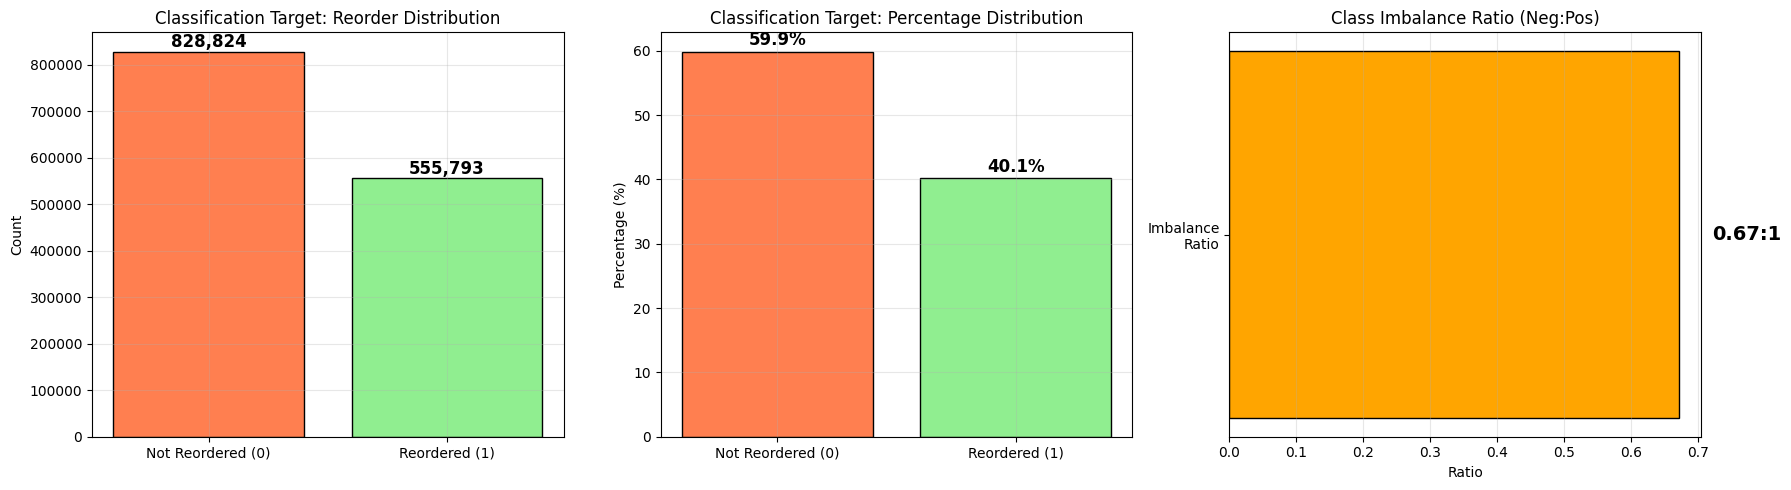

In [67]:
print("\n" + "="*80)
print("TARGET VARIABLE CREATION & ANALYSIS")
print("="*80)

# ----REORDER CLASSIFICATION (Binary) ----
print("\n[TASK A - CLASSIFICATION TARGET]")
print("Creating reorder binary labels for user-product pairs...")

# The train set has 'reordered' column (0 or 1)
reorder_target = order_products_train[['order_id', 'product_id', 'reordered']].copy()

# Merge with user information
train_orders = orders[orders.eval_set == 'train'][['order_id', 'user_id']]
reorder_target = reorder_target.merge(train_orders, on='order_id')

print(f"Total user-product pairs in train: {len(reorder_target):,}")
print(f"\nClass Distribution:")
print(reorder_target['reordered'].value_counts())
print(f"\nClass Proportions:")
print(reorder_target['reordered'].value_counts(normalize=True))

# Visualize class imbalance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Count plot
reorder_counts = reorder_target['reordered'].value_counts()
axes[0].bar(['Not Reordered (0)', 'Reordered (1)'], reorder_counts.values,
           color=['coral', 'lightgreen'], edgecolor='black')
axes[0].set_title('Classification Target: Reorder Distribution')
axes[0].set_ylabel('Count')
axes[0].grid(alpha=0.3)
for i, v in enumerate(reorder_counts.values):
    axes[0].text(i, v + 10000, f'{v:,}', ha='center', fontsize=12, fontweight='bold')

# Percentage plot
reorder_pct = reorder_target['reordered'].value_counts(normalize=True) * 100
axes[1].bar(['Not Reordered (0)', 'Reordered (1)'], reorder_pct.values,
           color=['coral', 'lightgreen'], edgecolor='black')
axes[1].set_title('Classification Target: Percentage Distribution')
axes[1].set_ylabel('Percentage (%)')
axes[1].grid(alpha=0.3)
for i, v in enumerate(reorder_pct.values):
    axes[1].text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=12, fontweight='bold')

# Imbalance ratio
imbalance_ratio = reorder_counts[0] / reorder_counts[1]
axes[2].barh(['Imbalance\nRatio'], [imbalance_ratio], color='orange', edgecolor='black')
axes[2].set_title('Class Imbalance Ratio (Neg:Pos)')
axes[2].set_xlabel('Ratio')
axes[2].text(imbalance_ratio + 0.05, 0, f'{imbalance_ratio:.2f}:1',
            va='center', fontsize=14, fontweight='bold')
axes[2].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()



PRODUCT-LEVEL STATISTICS

 Product Statistics Summary:
        total_orders  reorder_rate  avg_cart_position
count   49677.000000  49677.000000       49677.000000
mean      652.907563      0.366461           9.097568
std      4792.114416      0.208103           2.551267
min         1.000000      0.000000           1.000000
25%        17.000000      0.208075           7.625850
50%        60.000000      0.376623           9.057269
75%       260.000000      0.529307          10.356401
max    472565.000000      0.941176          53.000000

Top 10 Most Popular Products:
          product_name  total_orders  reorder_rate
                Banana        472565      0.843501
Bag of Organic Bananas        379450      0.832555
  Organic Strawberries        264683      0.777704
  Organic Baby Spinach        241921      0.772500
  Organic Hass Avocado        213584      0.796553
       Organic Avocado        176815      0.758103
           Large Lemon        152657      0.696038
          Strawberr

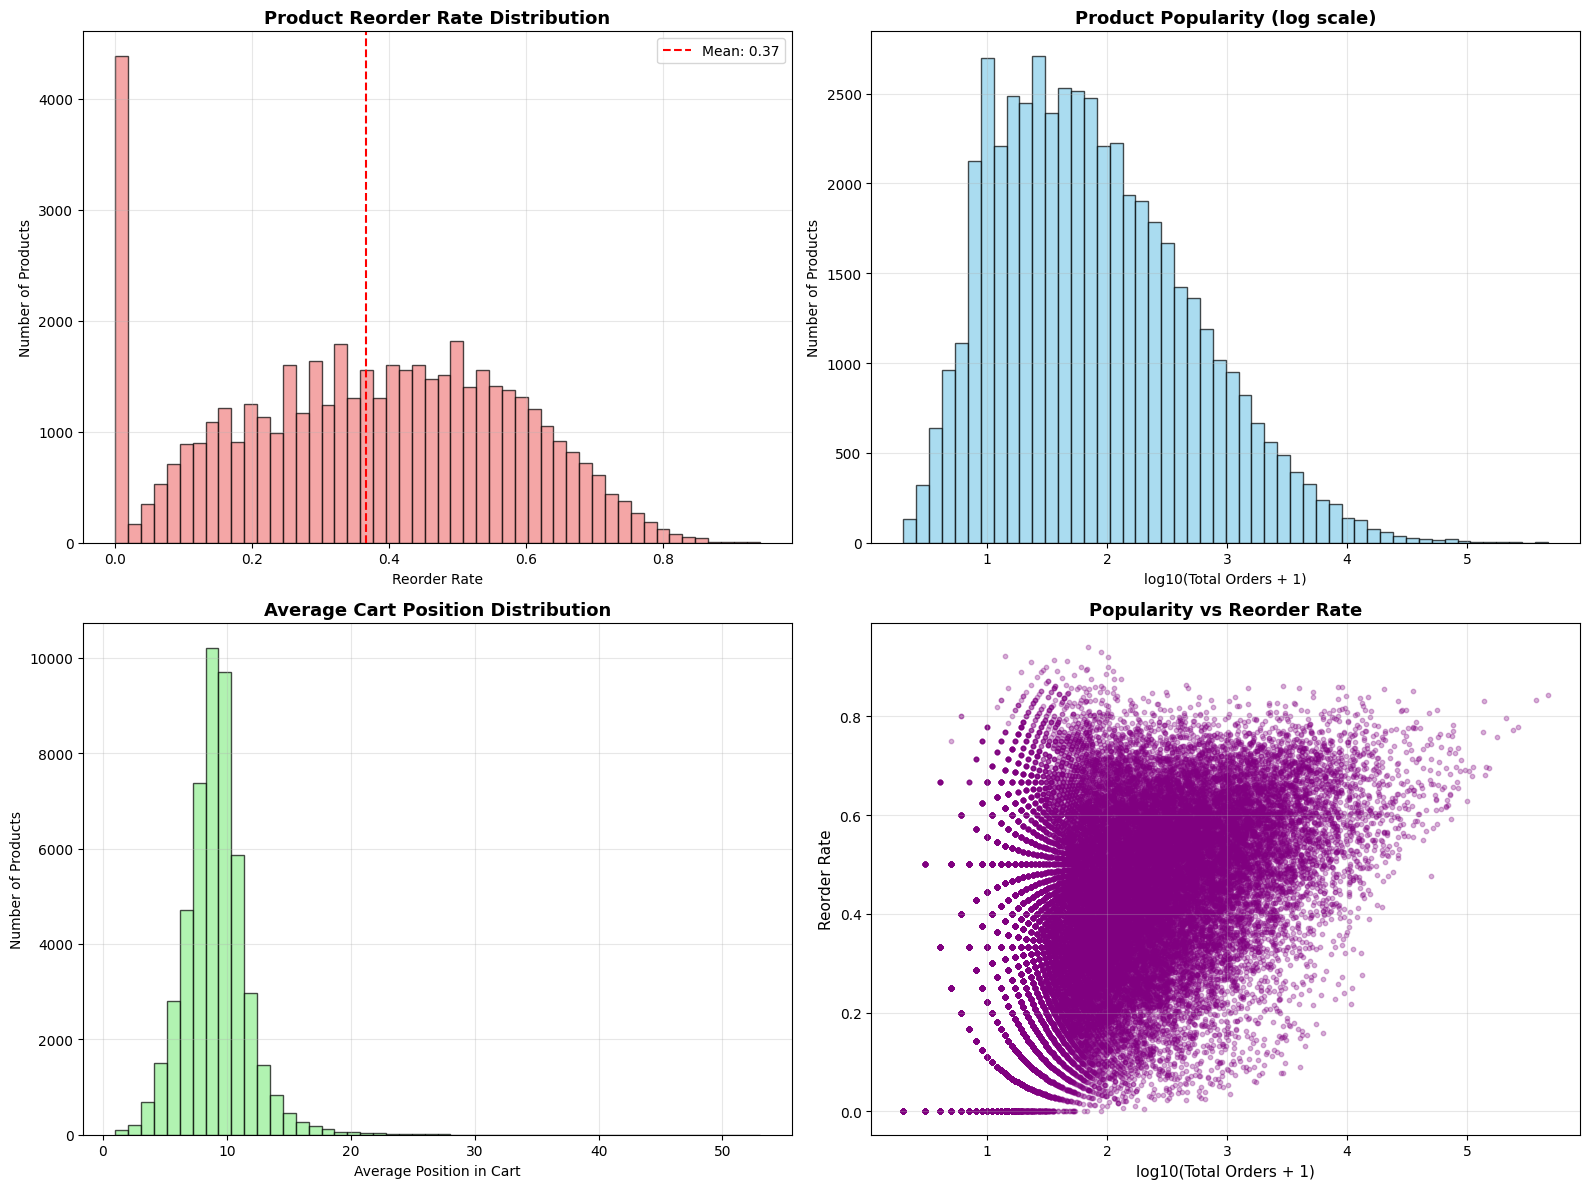


USER-LEVEL STATISTICS

👥 User Statistics Summary:
       total_orders  avg_days_between  max_order_number  avg_basket_size
count     206209.00         206209.00         206209.00        206209.00
mean          15.59             12.80             15.59             9.95
std           16.65              5.38             16.65             5.86
min            3.00              0.00              3.00             1.00
25%            5.00              8.50              5.00             5.74
50%            9.00             12.61              9.00             8.93
75%           19.00             17.00             19.00            13.00
max           99.00             26.91             99.00            70.25


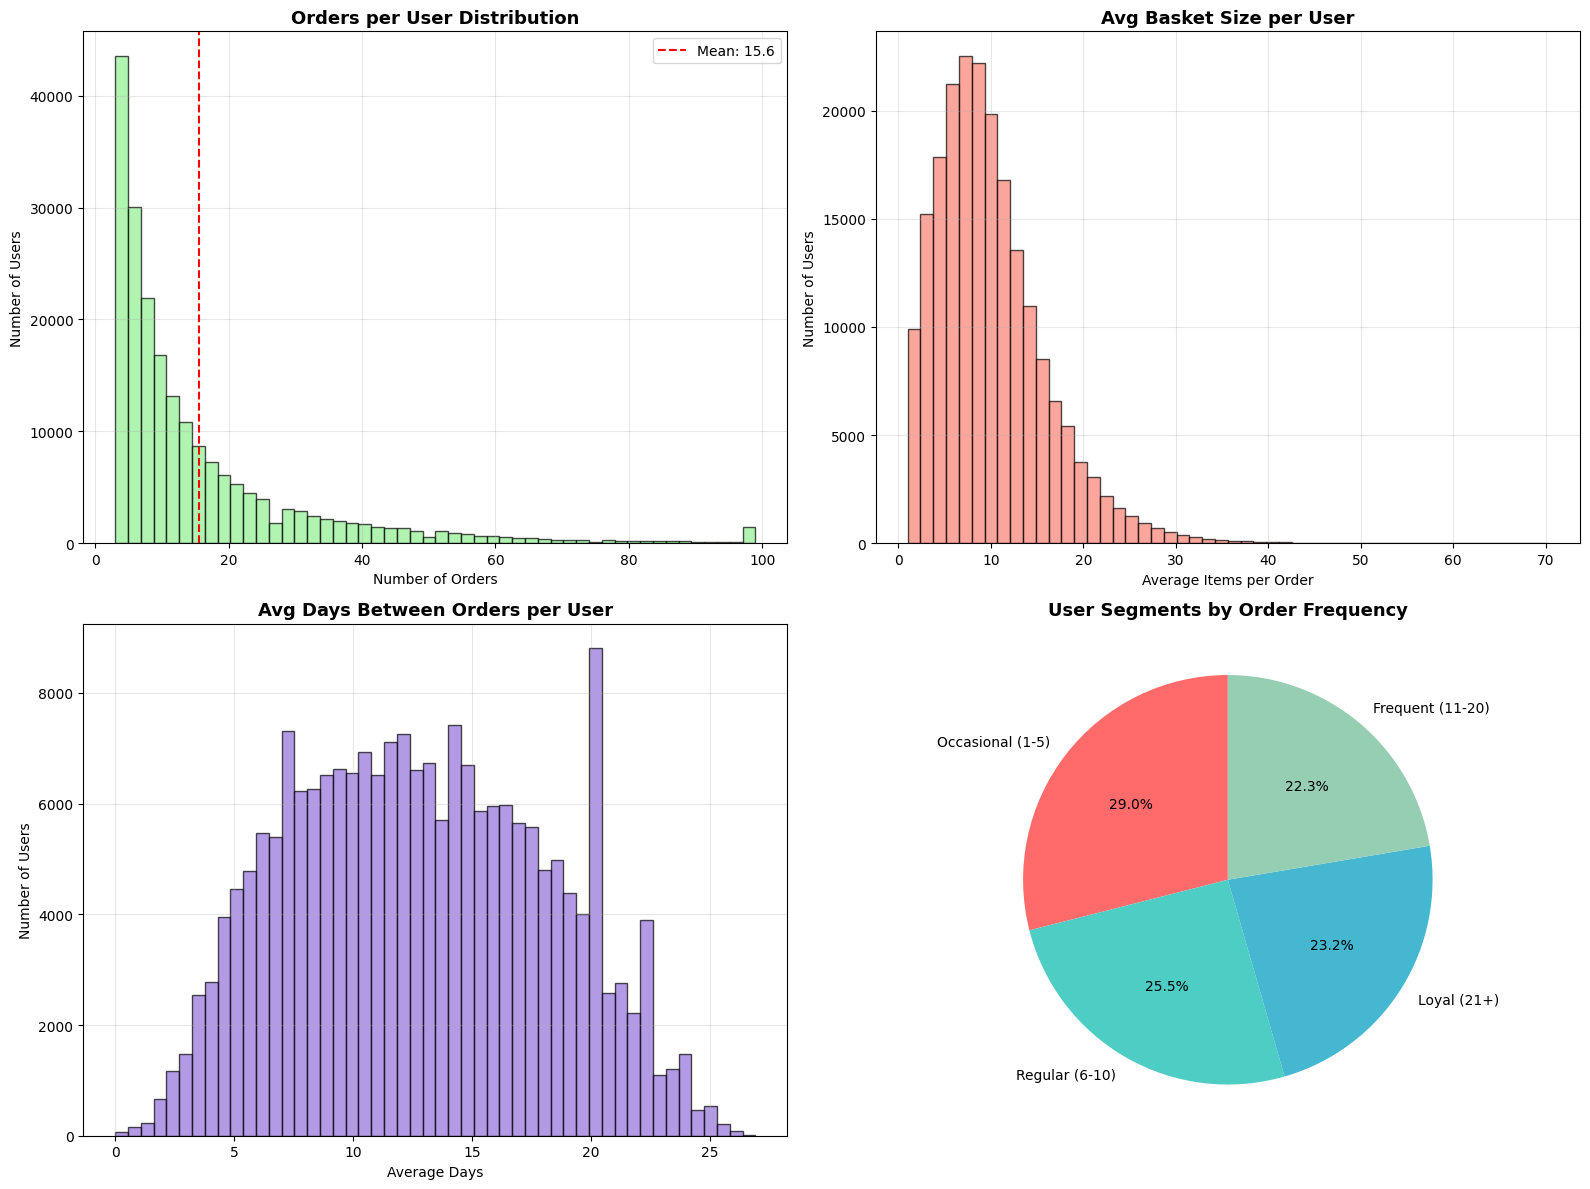


USER SEGMENTATION:
  • Occasional (1-5): 59,741 users (29.0%)
  • Regular (6-10): 52,587 users (25.5%)
  • Loyal (21+): 47,810 users (23.2%)
  • Frequent (11-20): 46,071 users (22.3%)

EDA COMPLETE ----- READY FOR FEATURE ENGINEERING


In [68]:
print("\n" + "="*80)
print("PRODUCT-LEVEL STATISTICS")
print("="*80)

# Product statistics
product_stats = order_products_prior.groupby('product_id').agg({
    'order_id': 'count',
    'reordered': 'mean',
    'add_to_cart_order': 'mean'
}).rename(columns={
    'order_id': 'total_orders',
    'reordered': 'reorder_rate',
    'add_to_cart_order': 'avg_cart_position'
})

product_stats = product_stats.merge(products[['product_id', 'product_name']],
                                   on='product_id', how='left')

print(f"\n Product Statistics Summary:")
print(product_stats[['total_orders', 'reorder_rate', 'avg_cart_position']].describe())

print(f"\nTop 10 Most Popular Products:")
top_products = product_stats.nlargest(10, 'total_orders')
print(top_products[['product_name', 'total_orders', 'reorder_rate']].to_string(index=False))

print(f"\n Top 10 Highest Reorder Rate (min 100 orders):")
high_reorder = product_stats[product_stats['total_orders'] >= 100].nlargest(10, 'reorder_rate')
print(high_reorder[['product_name', 'total_orders', 'reorder_rate']].to_string(index=False))

# Visualize product distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Reorder rate distribution
axes[0, 0].hist(product_stats['reorder_rate'], bins=50, edgecolor='black',
               alpha=0.7, color='lightcoral')
axes[0, 0].set_title('Product Reorder Rate Distribution', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Reorder Rate')
axes[0, 0].set_ylabel('Number of Products')
axes[0, 0].axvline(product_stats['reorder_rate'].mean(), color='red',
                   linestyle='--', label=f"Mean: {product_stats['reorder_rate'].mean():.2f}")
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Product popularity (log scale)
axes[0, 1].hist(np.log10(product_stats['total_orders'] + 1), bins=50,
               edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 1].set_title('Product Popularity (log scale)', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('log10(Total Orders + 1)')
axes[0, 1].set_ylabel('Number of Products')
axes[0, 1].grid(alpha=0.3)

# Cart position distribution
axes[1, 0].hist(product_stats['avg_cart_position'], bins=50, edgecolor='black',
               alpha=0.7, color='lightgreen')
axes[1, 0].set_title('Average Cart Position Distribution', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Average Position in Cart')
axes[1, 0].set_ylabel('Number of Products')
axes[1, 0].grid(alpha=0.3)

# Scatter: Popularity vs Reorder Rate
axes[1, 1].scatter(np.log10(product_stats['total_orders'] + 1),
                  product_stats['reorder_rate'], alpha=0.3, s=10, color='purple')
axes[1, 1].set_xlabel('log10(Total Orders + 1)', fontsize=11)
axes[1, 1].set_ylabel('Reorder Rate', fontsize=11)
axes[1, 1].set_title('Popularity vs Reorder Rate', fontsize=13, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ---- USER-LEVEL STATISTICS ----
print("\n" + "="*80)
print("USER-LEVEL STATISTICS")
print("="*80)

user_stats = orders[orders.eval_set == 'prior'].groupby('user_id').agg({
    'order_id': 'count',
    'days_since_prior_order': 'mean',
    'order_number': 'max'
}).rename(columns={
    'order_id': 'total_orders',
    'days_since_prior_order': 'avg_days_between',
    'order_number': 'max_order_number'
})

# Add average basket size per user
user_basket = order_products_prior.groupby('order_id').size().rename('basket_size')
user_basket = orders[orders.eval_set == 'prior'][['order_id', 'user_id']].merge(
    user_basket, left_on='order_id', right_index=True
).groupby('user_id')['basket_size'].mean().rename('avg_basket_size')

user_stats = user_stats.merge(user_basket, left_index=True, right_index=True)

print(f"\n👥 User Statistics Summary:")
print(user_stats.describe().round(2))

# Visualize user distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Orders per user
axes[0, 0].hist(user_stats['total_orders'], bins=50, edgecolor='black',
               alpha=0.7, color='lightgreen')
axes[0, 0].set_title('Orders per User Distribution', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Number of Orders')
axes[0, 0].set_ylabel('Number of Users')
axes[0, 0].axvline(user_stats['total_orders'].mean(), color='red',
                   linestyle='--', label=f"Mean: {user_stats['total_orders'].mean():.1f}")
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Average basket size per user
axes[0, 1].hist(user_stats['avg_basket_size'], bins=50, edgecolor='black',
               alpha=0.7, color='salmon')
axes[0, 1].set_title('Avg Basket Size per User', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Average Items per Order')
axes[0, 1].set_ylabel('Number of Users')
axes[0, 1].grid(alpha=0.3)

# Days between orders per user
axes[1, 0].hist(user_stats['avg_days_between'], bins=50, edgecolor='black',
               alpha=0.7, color='mediumpurple')
axes[1, 0].set_title('Avg Days Between Orders per User', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Average Days')
axes[1, 0].set_ylabel('Number of Users')
axes[1, 0].grid(alpha=0.3)

# User segments based on order frequency
user_stats['segment'] = pd.cut(user_stats['total_orders'],
                               bins=[0, 5, 10, 20, 100],
                               labels=['Occasional (1-5)', 'Regular (6-10)',
                                     'Frequent (11-20)', 'Loyal (21+)'])
segment_counts = user_stats['segment'].value_counts()
axes[1, 1].pie(segment_counts.values, labels=segment_counts.index,
              autopct='%1.1f%%', startangle=90,
              colors=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[1, 1].set_title('User Segments by Order Frequency', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nUSER SEGMENTATION:")
for segment, count in segment_counts.items():
    pct = count / len(user_stats) * 100
    print(f"  • {segment}: {count:,} users ({pct:.1f}%)")

print("\n" + "="*80)
print("EDA COMPLETE ----- READY FOR FEATURE ENGINEERING")
print("="*80)
